# OTP Bank Contest
## Описание задачи

Один из способов повышения эффективности взаимодействия банка с клиентами заключается в том, чтобы отправлять предложение о новой услуге не всем клиентам банка, а только некоторой части, выбираемой по принципу наибольшей склонности к отклику на данное предложение.

Конкурсное задание заключается в том, чтобы предложить алгоритм, который будет выдавать оценку склонности клиента к положительному отклику по его признаковому описанию. Эта оценка может (хотя и не обязана) интерпретироваться как вероятность положительного отклика. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем клиентам, у которых значение оценки выше некоторого порога.

Ссылка на конкурс:
http://poligon.machinelearning.ru/Contests/Card.aspx?synonim=otp

# Быстрое-перемещение

1. [Эксплоративный анализ](#Эксплоративный-анализ)
    1. [Загружаем данные](#Загружаем-данные)
    1. [Дополнительные функции](#Дополнительные-функции)
    1. [Описание полей](#Описание-полей)
    1. [Обрабатываем пропущенные значения](#Обрабатываем-пропущенные-значения)
    1. [Вывод о WORK_TIME](#Вывод-о-WORK_TIME)
    1. [Преобразуем численные значения](#Преобразуем-численные-значения)
    1. [Бининг](#Бининг)
    1. [Добавление фичей](#Добавление-фичей)
    1. [Обработка численных полей](#Обработка-численных-полей)  
      
1. [Data Processing Tool](#Data-Processing-Tool)
    1. [Первая версия](#Первая-версия)
    1. [Вторая версия](#Вторая-версия)
    1. [Построение RF без подгонки параметров](#Построение-RF-без-подгонки-параметров)
1. [Построение моделей](#Построение-моделей)

# Эксплоративный анализ
[Вернуться к быстрому перемещению](#Быстрое-перемещение)

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.display import display
plt.rc('font', family='Verdana')

import warnings
warnings.filterwarnings('ignore')

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

In [3]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Загружаем данные

In [4]:
data = pd.read_csv("data/Credit_OTP.csv", encoding='cp1251', sep = ';')
data.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,DL_DOCUMENT_FL,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
0,59910150,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,8000,6,8650,0,1,220,18.0000,0,0,1,1,1,6,2,1,1580,1580,nan
1,59910230,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,0,0,0,0,21650,6,4000,0,1,137,97.0000,1,0,1,1,1,6,1,1,4020,4020,nan
2,59910525,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Информационные технологии,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,33126,12,4000,0,1,251,84.0000,0,0,1,2,1,11,0,0,0,0,nan
3,59910803,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,0,1,0,0,1,1,0,0,0,0,0,0,"8491,82",6,5000,0,0,36,168.0000,1,1,1,1,1,6,3,1,"1589,923333",1590,nan
4,59911781,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,1,0,0,0,21990,12,4000,0,1,83,101.0000,1,0,1,2,1,16,2,1,"1152,15",2230,nan


## Дополнительные функции

In [5]:
def small_categories_aggregation(column, n_samples, value='Укрупненная категория', dataset=data):
    '''
    Укрупняет категории и числовые столбцы в датасете
    :param column: имя стоблца в датасете data
    :param n_samples: порог наблюдений, ниже которого категории объединяются в одну
    :param value: значение, которым будет заполнено
    :param dataset: датасет для изменения
    :return:
    '''

    tmp_small_columns = dataset[column].value_counts()[dataset[column].value_counts() < n_samples].index

    for col in tmp_small_columns:
        dataset.at[dataset[column] == col, column] = value
        
        
def show_columns_with_missing(dataset=data):
    '''
    показать столбцы, где есть пропущенные значения
    :param dataset: датасет
    :return:
    '''
    
    miss_columns = dataset.count(axis=0)[dataset.count(axis=0) < len(dataset)].index

    for i in miss_columns:
        print(dataset.isnull()[i].value_counts())
        print()

    display(miss_columns)
    

def columns(dataset=data):
    
    categorical_columns = [col for col in dataset.columns if dataset[col].dtype.name == 'object']
    numerical_columns = [col for col in dataset.columns if dataset[col].dtype.name != 'object']
    
    return categorical_columns, numerical_columns
    

cat_columns, num_columns = columns()
    
    
def show_binning(dataset=data, categorical_columns=cat_columns):

    columns_to_enlargment = []

    for column in categorical_columns:
        if dataset[column].value_counts().values[-1] < len(dataset)/100:
            columns_to_enlargment.append(column)
            print(dataset[column].value_counts())
            print()
            
    return columns_to_enlargment

In [5]:
# указано в условии
data['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0, inplace=True)

# удаляем id
data.drop('AGREEMENT_RK', axis=1, inplace=True)

## Описание полей

In [6]:
pd.read_excel('data/Credit_OTP_columns_description.xls')

,ПОЛЕ,ОПИСАНИЕ
0,AGREEMENT_RK,уникальный идентификатор объекта в выборке
1,TARGET,целевая переменная:отклик на маркетинговую кам...
2,AGE,возраст клиента
3,SOCSTATUS_WORK_FL,социальный статус клиента относительно работы ...
4,SOCSTATUS_PENS_FL,социальный статус клиента относительно пенсии ...
5,GENDER,"пол клиента (1 - мужчина, 0 - женщина)"
6,CHILD_TOTAL,количество детей клиента
7,DEPENDANTS,количество иждивенцев клиента
8,EDUCATION,образование
9,MARITAL_STATUS,семейное положение


In [7]:
categorical_columns = ['TARGET', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'GENDER', 'EDUCATION', 'MARITAL_STATUS', 
                       'GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR',
                       'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE',
                       'REGION_NM', 'REG_FACT_FL', 'FACT_POST_FL', 'REG_POST_FL', 'REG_FACT_POST_FL', 
                       'REG_FACT_POST_TP_FL', 'FL_PRESENCE_FL', 'AUTO_RUS_FL', 'HS_PRESENCE_FL',
                       'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL', 'DL_DOCUMENT_FL',
                       'GPF_DOCUMENT_FL', 'FACT_PHONE_FL', 'REG_PHONE_FL', 'GEN_PHONE_FL']

## Обрабатываем пропущенные значения

In [8]:
# уникальные значения
for i in data.columns:
    print(i)
    print(data[i].unique())
    print()

TARGET
[0 1]

AGE
[49 32 52 39 30 29 35 41 53 43 54 26 62 45 38 65 34 28 37 42 33 27 31 40 63
 61 44 59 48 24 23 47 58 51 56 22 36 57 50 46 55 66 25 60 64 21 67]

SOCSTATUS_WORK_FL
[1 0]

SOCSTATUS_PENS_FL
[0 1]

GENDER
[1 0]

CHILD_TOTAL
[ 2  3  4  1  0  5  6  7  8 10]

DEPENDANTS
[1 3 0 2 4 5 6 7]

EDUCATION
['Среднее специальное' 'Среднее' 'Неполное среднее' 'Высшее'
 'Неоконченное высшее' 'Два и более высших образования' 'Ученая степень']

MARITAL_STATUS
['Состою в браке' 'Гражданский брак' 'Разведен(а)' 'Не состоял в браке'
 'Вдовец/Вдова']

GEN_INDUSTRY
['Торговля' 'Информационные технологии' 'Образование'
 'Государственная служба' 'Другие сферы' 'Сельское хозяйство'
 'Здравоохранение' 'Металлургия/Промышленность/Машиностроение' nan
 'Коммунальное хоз-во/Дорожные службы' 'Строительство' 'Транспорт'
 'Банк/Финансы' 'Ресторанный бизнес/Общественное питание' 'Страхование'
 'Нефтегазовая промышленность' 'СМИ/Реклама/PR-агенства' 'Энергетика'
 'Салоны красоты и здоровья' 'ЧОП/Детектив

In [9]:
# одно уникальное значение, удаляем
data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)

In [10]:
show_columns_with_missing()

False    13856
True      1367
Name: GEN_INDUSTRY, dtype: int64

False    13856
True      1367
Name: GEN_TITLE, dtype: int64

False    13856
True      1367
Name: ORG_TP_STATE, dtype: int64

False    13858
True      1365
Name: ORG_TP_FCAPITAL, dtype: int64

False    13856
True      1367
Name: JOB_DIR, dtype: int64

False    14928
True       295
Name: TP_PROVINCE, dtype: int64

False    15222
True         1
Name: REGION_NM, dtype: int64

False    13855
True      1368
Name: WORK_TIME, dtype: int64



Index(['GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL',
       'JOB_DIR', 'TP_PROVINCE', 'REGION_NM', 'WORK_TIME'],
      dtype='object')

In [11]:
# переводим в категориальные значения
for i in categorical_columns:
    if i in data.columns:
        data[i]=data[i].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 50 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null object
REG_ADDRESS_PROVINCE          15223 non-null object
FACT_ADDRE

In [12]:
show_columns_with_missing()

False    13855
True      1368
Name: WORK_TIME, dtype: int64



Index(['WORK_TIME'], dtype='object')

In [13]:
# если человек нигде не работает, то WORK_TIME = 0
data.at[(data['GEN_INDUSTRY'] == 'nan') & (data['GEN_TITLE'] == 'nan'), 'WORK_TIME'] = 0

In [14]:
show_columns_with_missing()

False    15222
True         1
Name: WORK_TIME, dtype: int64



Index(['WORK_TIME'], dtype='object')

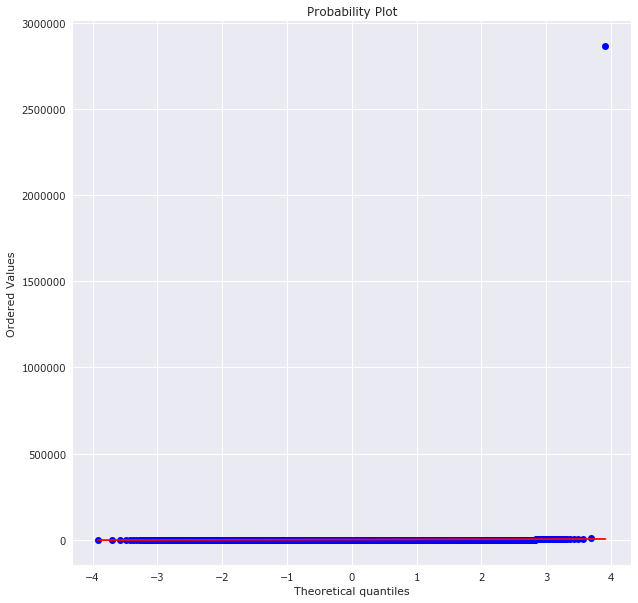

In [15]:
## QQ Plot для всех значений WORK_TIME
plt.subplots(figsize=(10, 10))

stats.probplot(data['WORK_TIME'].dropna().sort_values(), dist="norm", plot=plt)
plt.show()

In [16]:
# эспериментально выбранное значение
heu_const_work_time = 15200

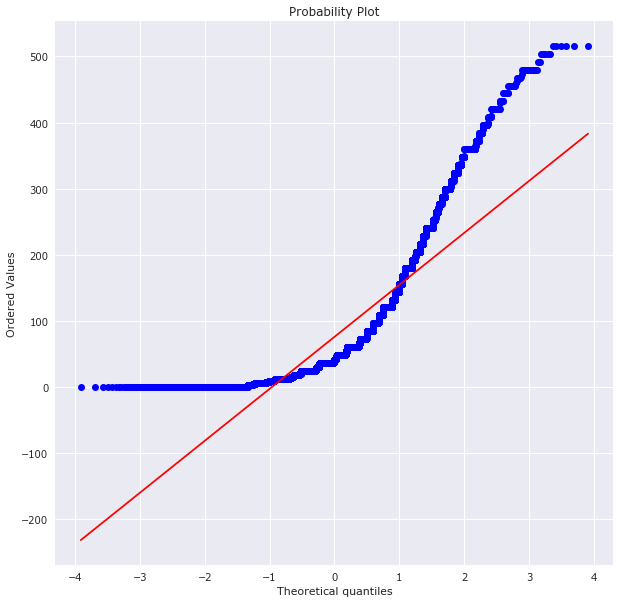

In [17]:
plt.subplots(figsize=(10, 10))

stats.probplot((data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time]), dist="norm", plot=plt)
plt.show()

### Распределения

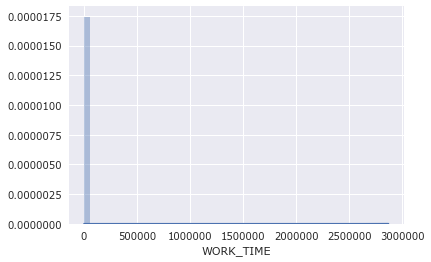

In [18]:
sns.distplot(data['WORK_TIME'].dropna().sort_values().dropna())

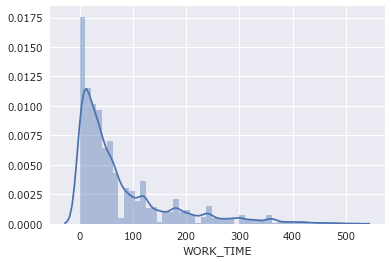

In [19]:
sns.distplot(data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].dropna())

In [20]:
# максимальное значение, после которого значения считаются "неправильными"
maxy_work_time = max(data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time])
maxy_work_time

516.0

In [21]:
# считаем значения больше maxy_work_time - пропущенными
data.at[data['WORK_TIME'] > maxy_work_time, 'WORK_TIME'] = np.NaN

# стало не слишком больше пропущенных значений
len(data['WORK_TIME']) - len(data['WORK_TIME'].dropna())

22

In [22]:
# значение медианы, не учитывающее замену некоторых пропущенных значений неработающих людей на 0
data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()

48.0

In [23]:
# аналогичное среднее
data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].mean()

83.04951568599104

median


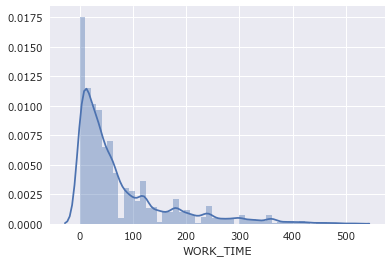

In [24]:
print('median')
sns.distplot(data['WORK_TIME'].fillna(data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()))

In [25]:
true_median = data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()
data['WORK_TIME'].fillna(true_median, inplace=True)

## Вывод о WORK_TIME
Для неработающих людей WORK_TIME заменили на ноль, было выявлено, что есть "неправильные" значения, то есть нельзя отработать 300 000 месяцев. Порог этих значений я определил по qq plot и выявил значение, больше которого значения считать правдивыми нельзя. Затем я заменил эти значения на пропуски и импутировал пропуски медианным значением WORK_TIME без учета 0 (неработающих) людей

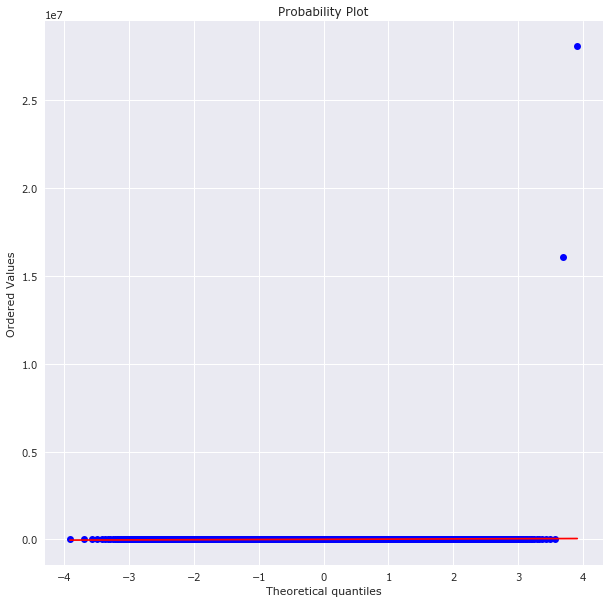

In [26]:
## QQ Plot
plt.subplots(figsize=(10, 10))

stats.probplot(data['FACT_LIVING_TERM'].dropna().sort_values(), dist="norm", plot=plt)
plt.show()

### Ситуация аналогична WORK_TIME

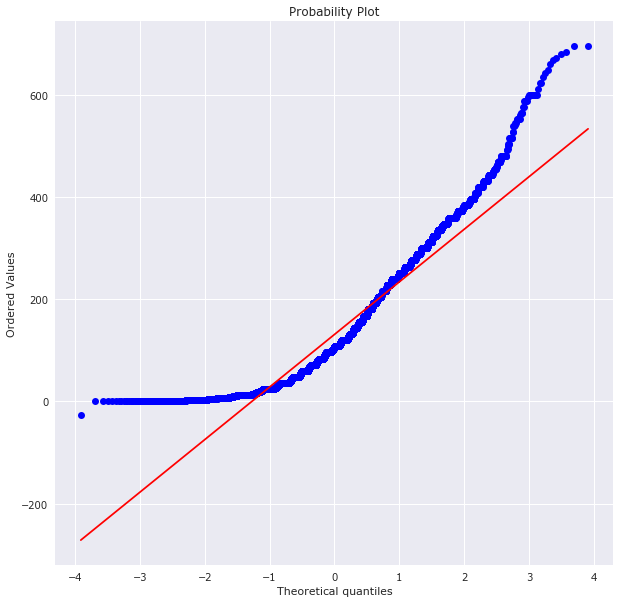

In [27]:
## QQ Plot
plt.subplots(figsize=(10, 10))

stats.probplot(data['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time], dist="norm", plot=plt)
plt.show()

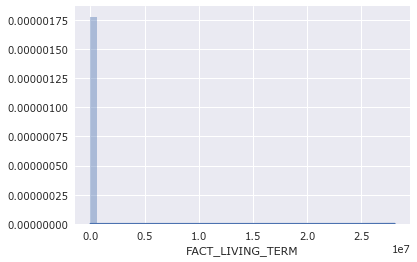

In [28]:
sns.distplot(data['FACT_LIVING_TERM'].dropna().sort_values())

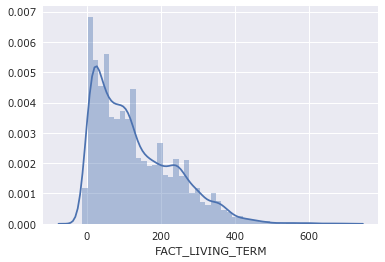

In [29]:
sns.distplot(data['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time])

In [30]:
data[data['FACT_LIVING_TERM'] < 0]

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
6246,0,56,1,0,1,0,0,Высшее,Состою в браке,Строительство,Высококвалифиц. специалист,Частная компания,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,23000,Приморский край,Приморский край,Приморский край,Приморский край,ДАЛЬНЕВОСТОЧНЫЙ,1,1,1,1,1,1,0,0,0,1,0,0,98136,24,40664,1,-26,288.0000,1,0,1,1,0,4,0,0,0,0,0.0000


In [31]:
data.at[data['FACT_LIVING_TERM'] < 0, 'FACT_LIVING_TERM'] = 0

In [32]:
maxy_live_term = max(data['FACT_LIVING_TERM'].sort_values()[:heu_const_work_time])

In [33]:
# считаем значения больше maxy_work_time - пропущенными
data.at[data['FACT_LIVING_TERM'] > maxy_live_term, 'FACT_LIVING_TERM'] = np.NaN

# стало не слишком больше пропущенных значений
len(data['FACT_LIVING_TERM']) - len(data['FACT_LIVING_TERM'].dropna())

23

median


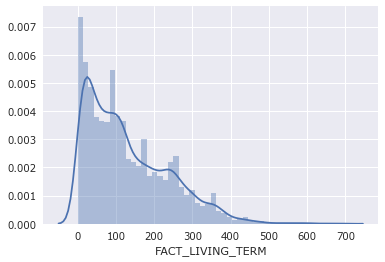

In [34]:
print('median')
sns.distplot(data['FACT_LIVING_TERM'].fillna(data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()))

In [35]:
true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()
data['FACT_LIVING_TERM'].fillna(true_median, inplace=True)

## Преобразуем численные значения

In [36]:
for i in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
    if i in data.columns:
        data[i] = data[i].str.replace(',', '.').astype('float')

In [37]:
cat_columns, num_columns = columns()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 50 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRESS_PROVINCE          15223 non-null object
FACT_ADDR

In [38]:
data[cat_columns].describe()

,TARGET,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,GPF_DOCUMENT_FL,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL
count,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223
unique,2,2,2,2,7,5,32,13,6,3,11,5,81,81,80,71,12,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,0,1,0,1,Среднее специальное,Состою в браке,Торговля,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,Кемеровская область,Кемеровская область,Кемеровская область,Краснодарский край,ЮЖНЫЙ,1,1,1,1,1,0,0,0,0,0,0,1,1,0,1
freq,13411,13847,13176,9964,6518,9416,2385,7010,6523,13688,11452,7077,674,674,674,790,2179,12765,14480,13493,12758,13782,10507,14097,11940,15074,14930,14558,8961,9311,14389,13855


In [39]:
data[num_columns].describe()

,AGE,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,OWN_AUTO,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
count,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000
mean,40.4061,1.0994,0.6452,13853.8363,0.1163,14667.9593,8.1010,3398.5627,131.0020,75.5412,1.3878,0.7519,7.8760,0.1954,0.1302,239.4571,243.0216,0.0191
std,11.6011,0.9954,0.8123,9015.4676,0.3208,12147.8735,4.0941,5158.1089,107.6183,89.5994,0.7936,0.9885,7.9557,0.6850,0.3557,827.7004,836.1001,0.1377
min,21.0000,0.0000,0.0000,24.0000,0.0000,2000.0000,3.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,30.0000,0.0000,0.0000,8000.0000,0.0000,6500.0000,6.0000,1000.0000,41.0000,14.0000,1.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,39.0000,1.0000,0.0000,12000.0000,0.0000,11550.0000,6.0000,2000.0000,107.0000,40.0000,1.0000,0.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,50.0000,2.0000,1.0000,17000.0000,0.0000,19170.0000,10.0000,4000.0000,204.0000,96.0000,2.0000,1.0000,8.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,67.0000,10.0000,7.0000,250000.0000,2.0000,119700.0000,36.0000,140000.0000,696.0000,516.0000,11.0000,11.0000,114.0000,13.0000,8.0000,28012.2000,28012.2000,2.0000


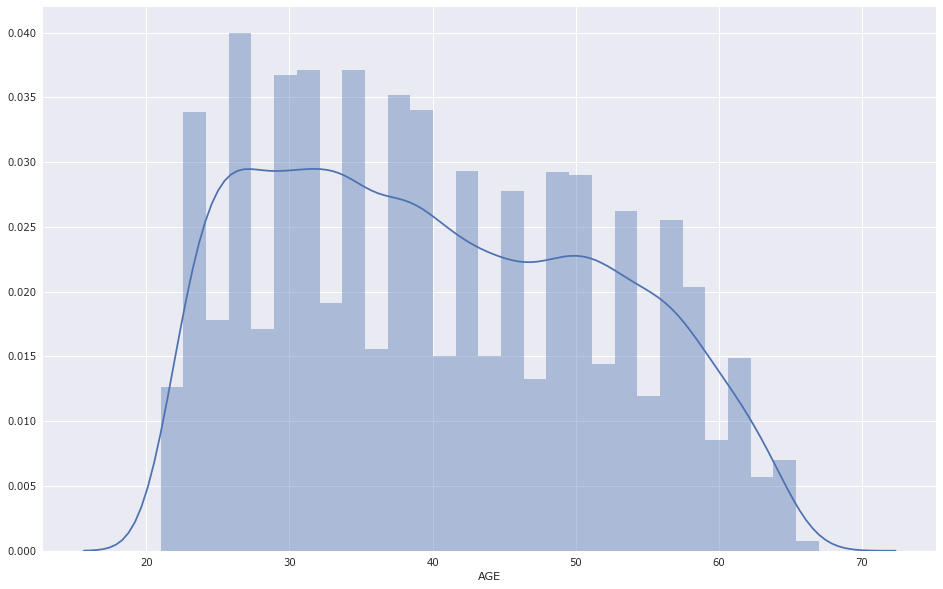

In [40]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[0]])

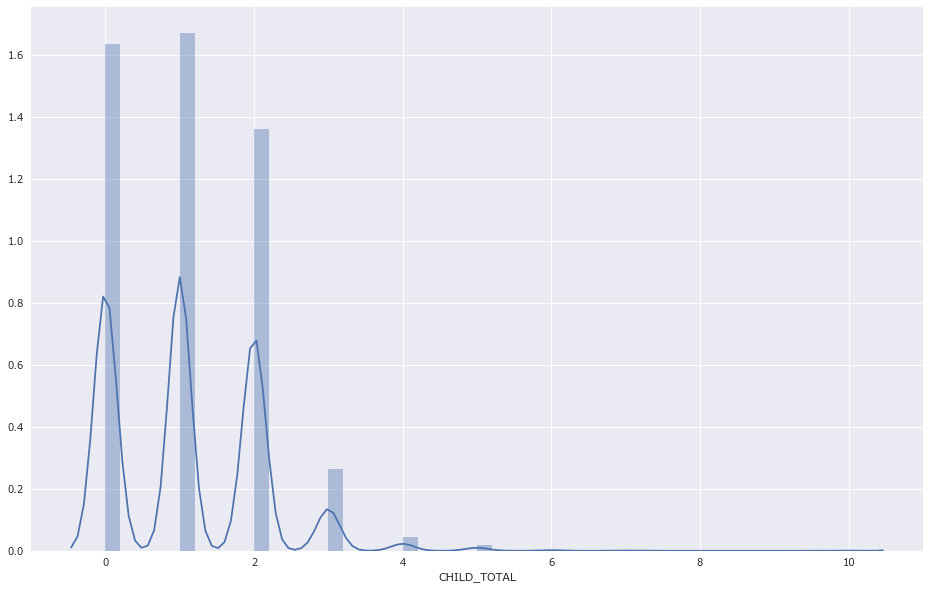

In [41]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[1]])

### Явно видно, что CHILD_TOTAL скорее категориальная переменная

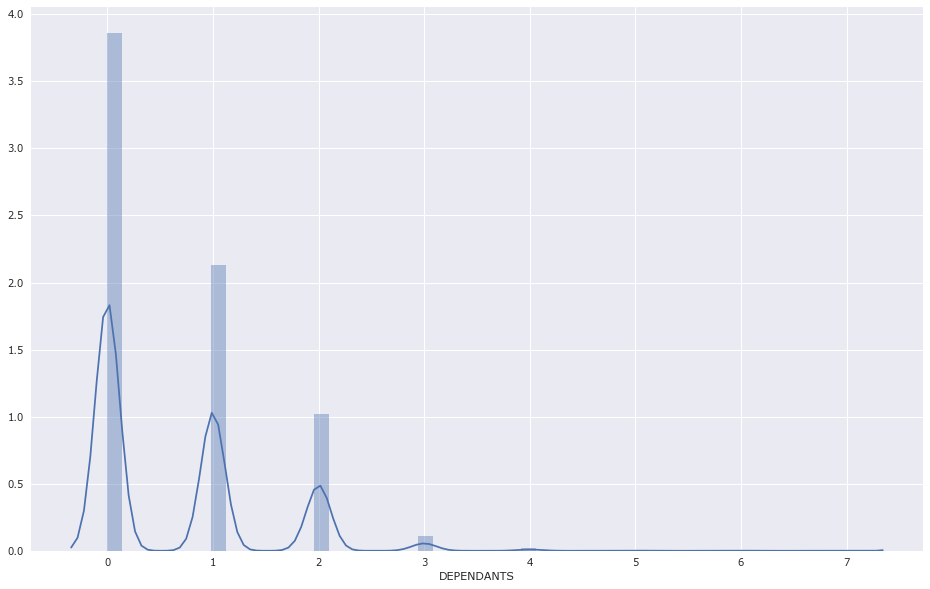

In [42]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[2]])

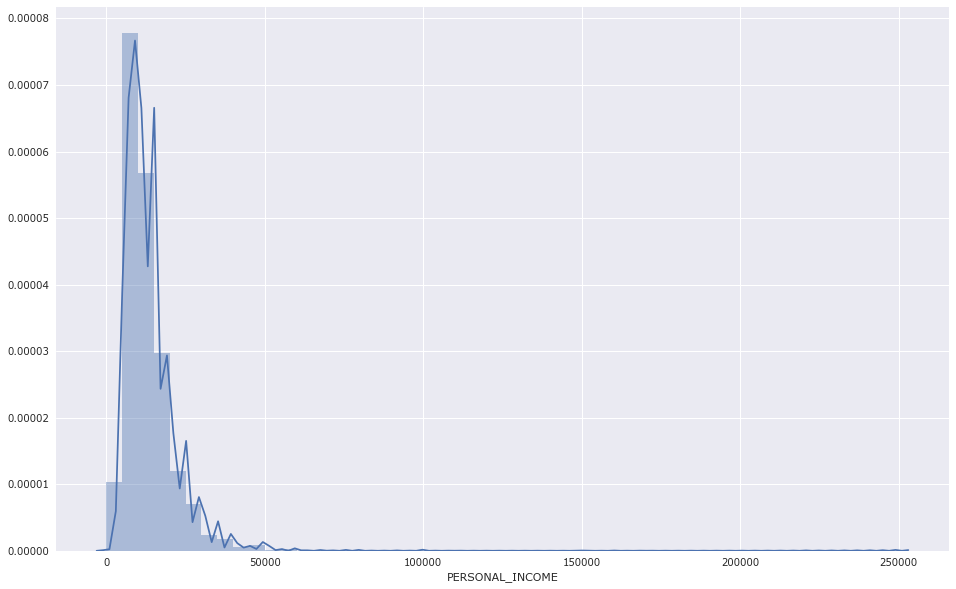

In [43]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[3]])

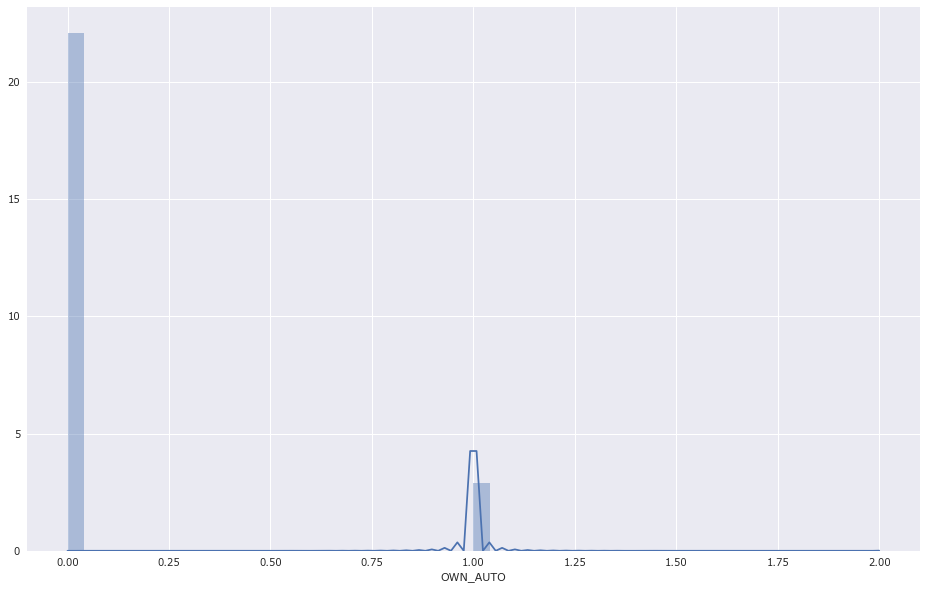

In [44]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[4]])

In [45]:
data['OWN_AUTO'].value_counts()

0    13453
1     1769
2        1
Name: OWN_AUTO, dtype: int64

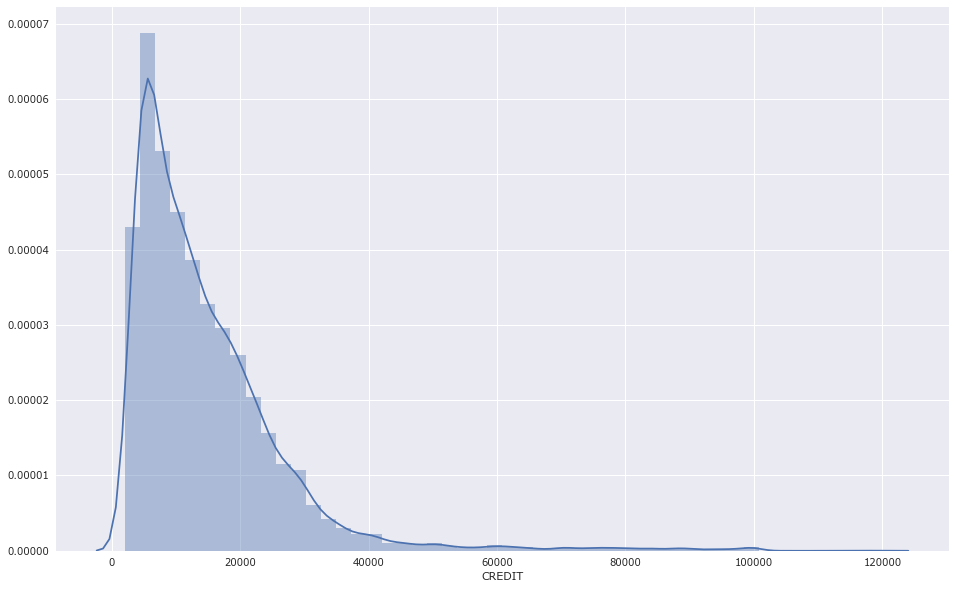

In [46]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[5]])

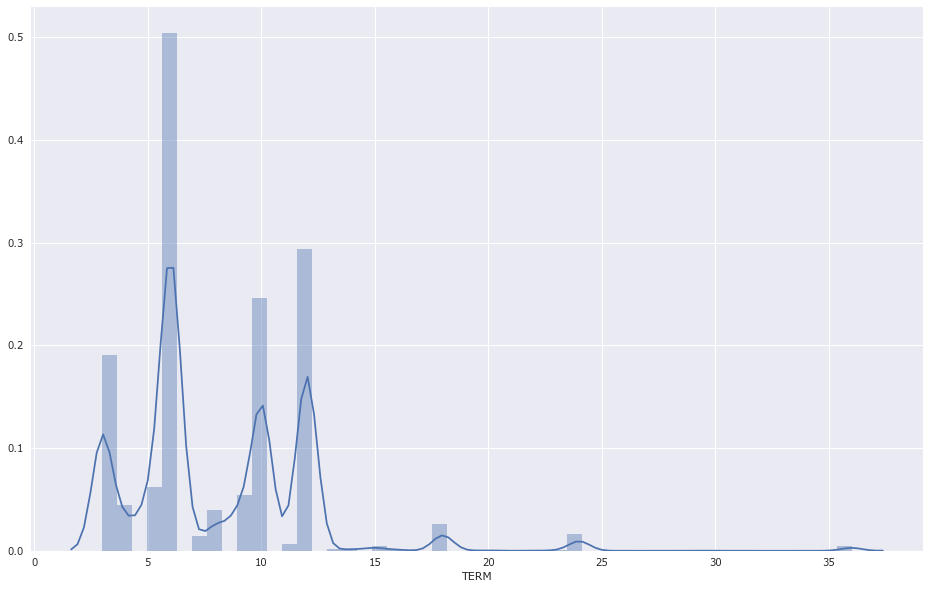

In [47]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[6]])

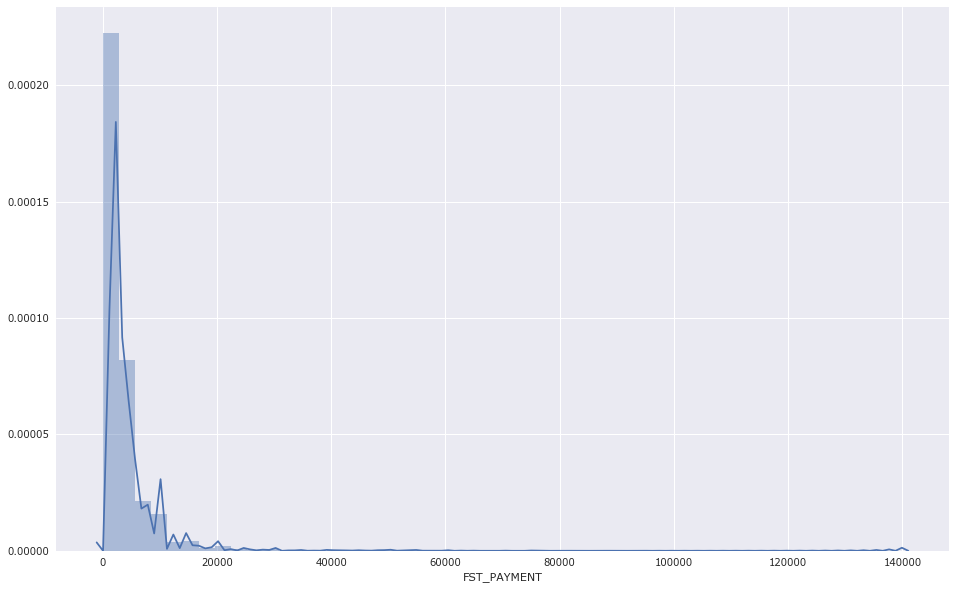

In [48]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[7]])

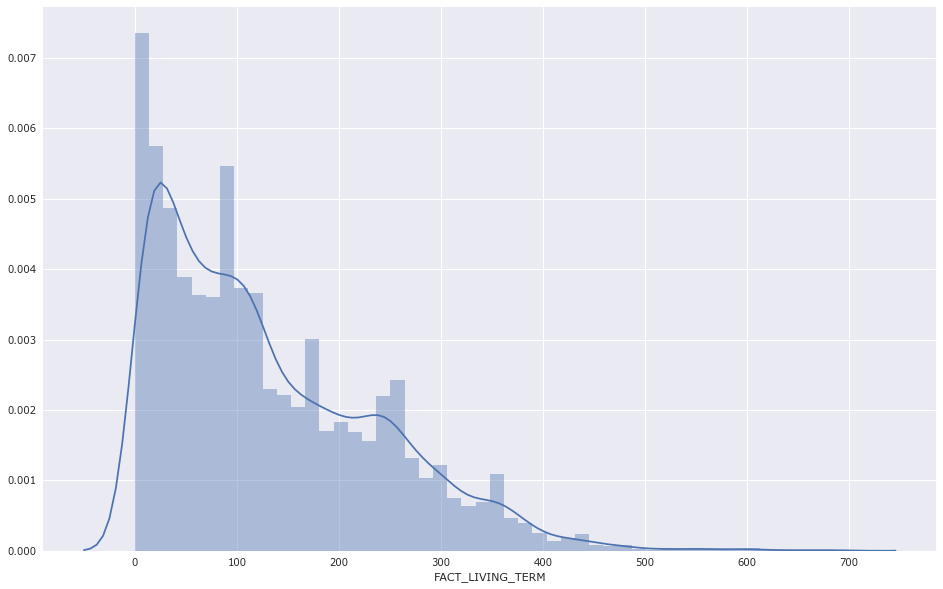

In [49]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[8]])

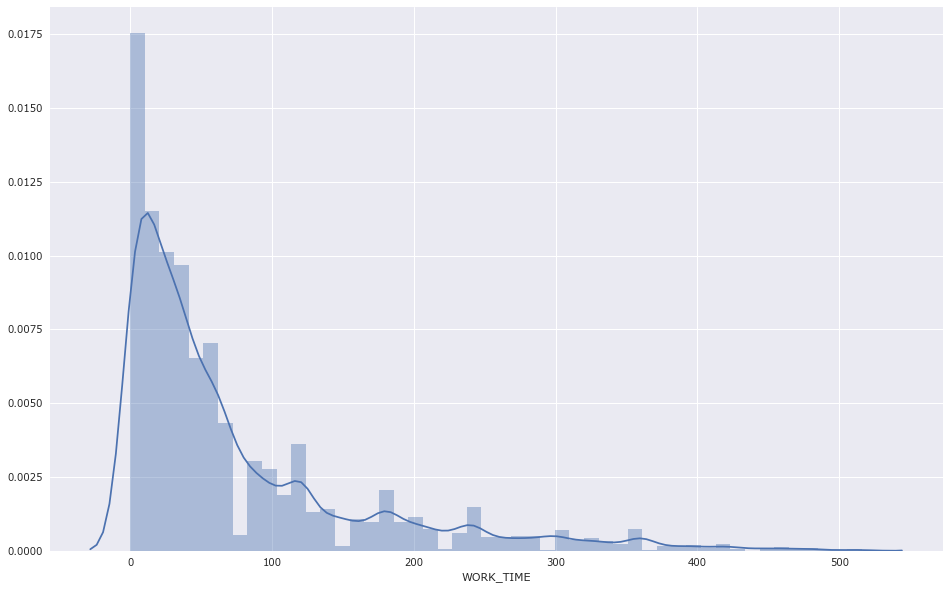

In [50]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[9]])

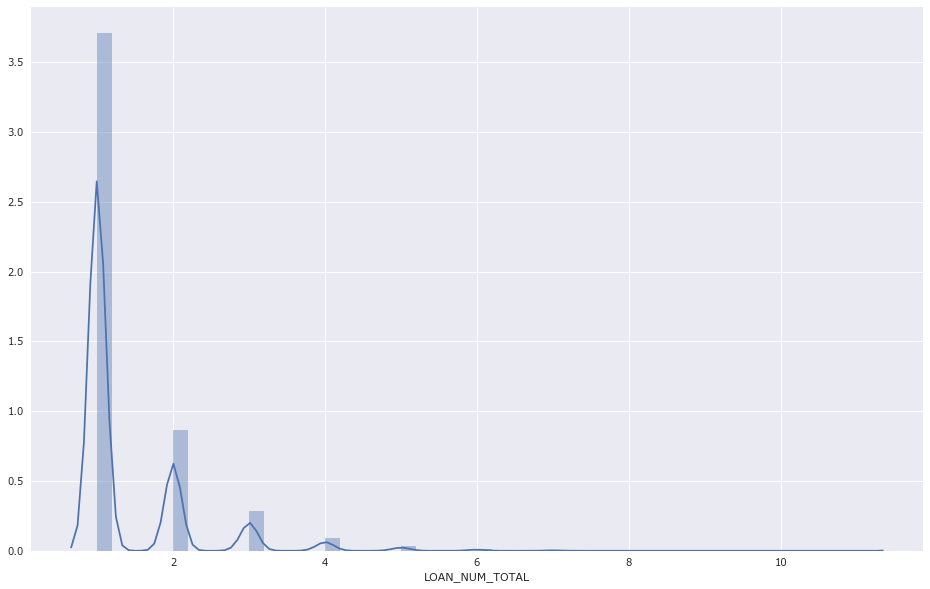

In [51]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[10]])

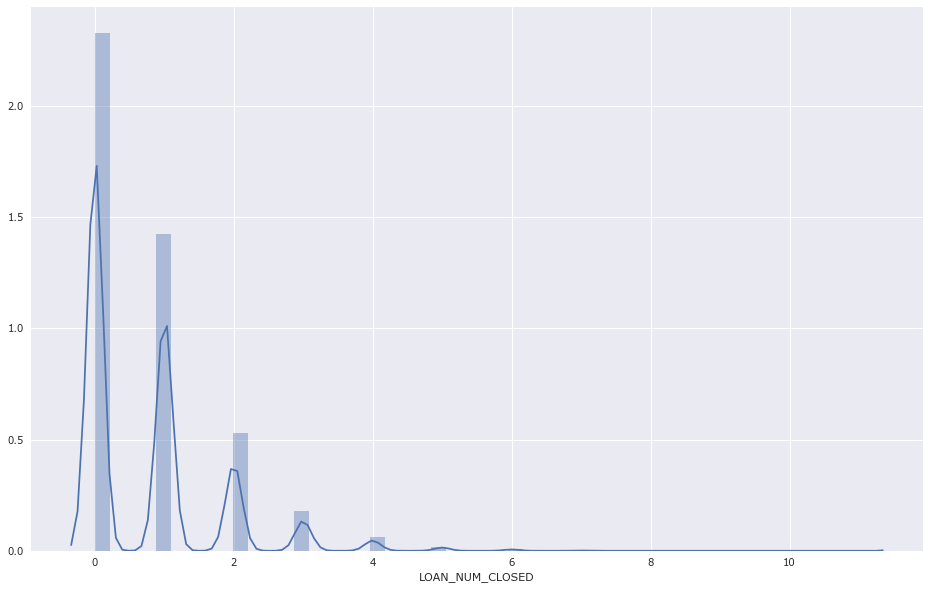

In [52]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[11]])

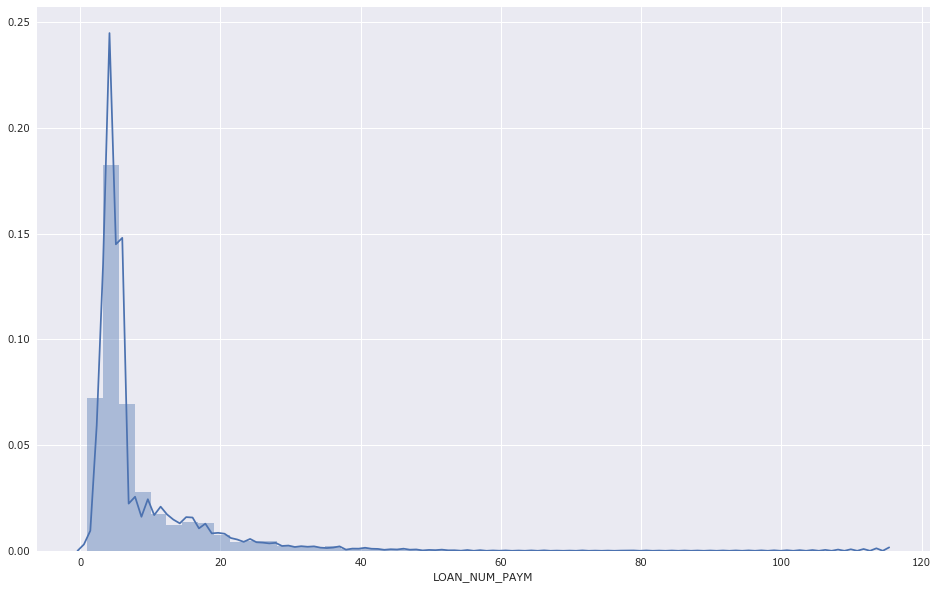

In [53]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[12]])

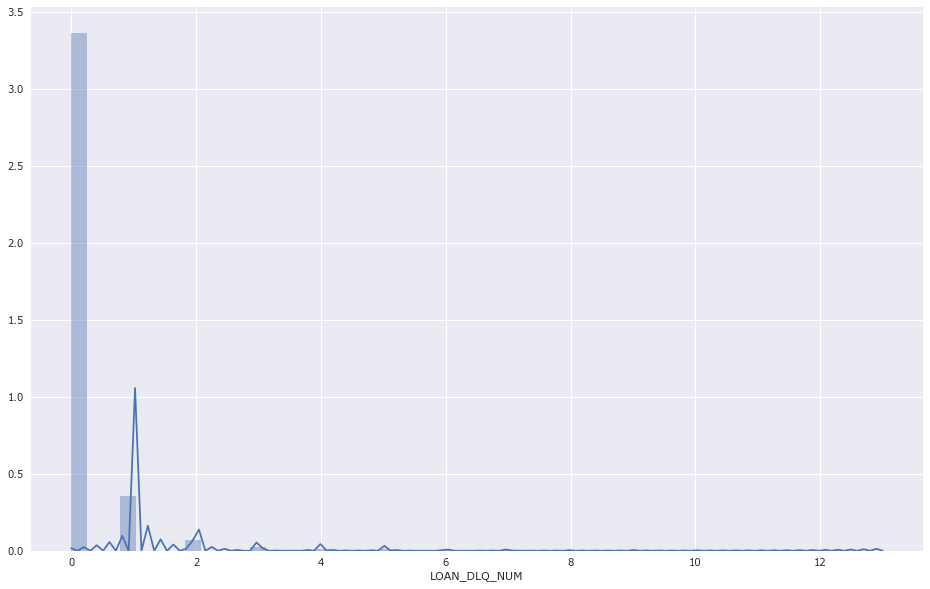

In [54]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[13]])

In [55]:
data['LOAN_DLQ_NUM'].value_counts()

0     13301
1      1416
2       280
3        96
4        48
5        39
6        16
7        14
9         4
8         3
13        2
10        2
12        1
11        1
Name: LOAN_DLQ_NUM, dtype: int64

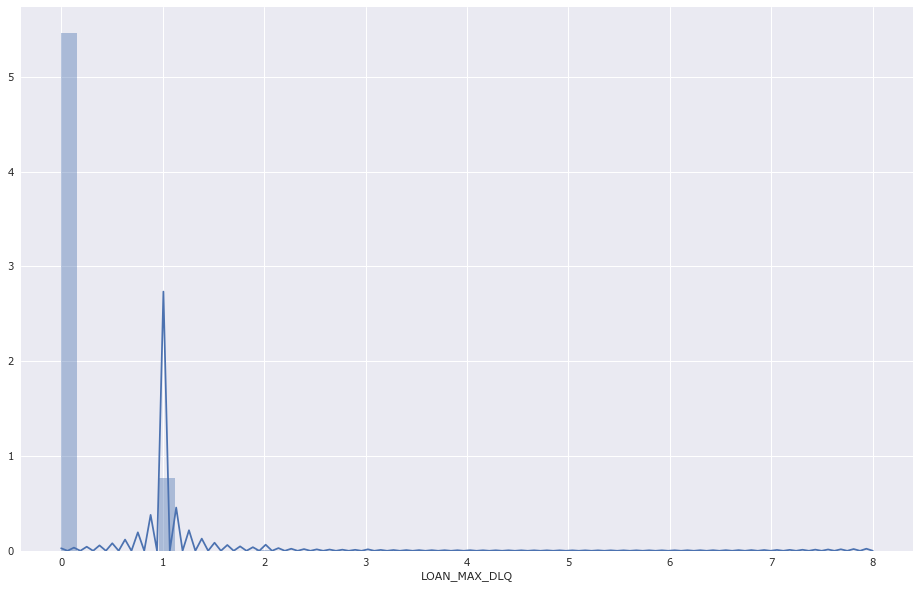

In [56]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[14]])

In [57]:
data['LOAN_MAX_DLQ'].value_counts()

0    13301
1     1881
2       31
3        7
6        1
4        1
8        1
Name: LOAN_MAX_DLQ, dtype: int64

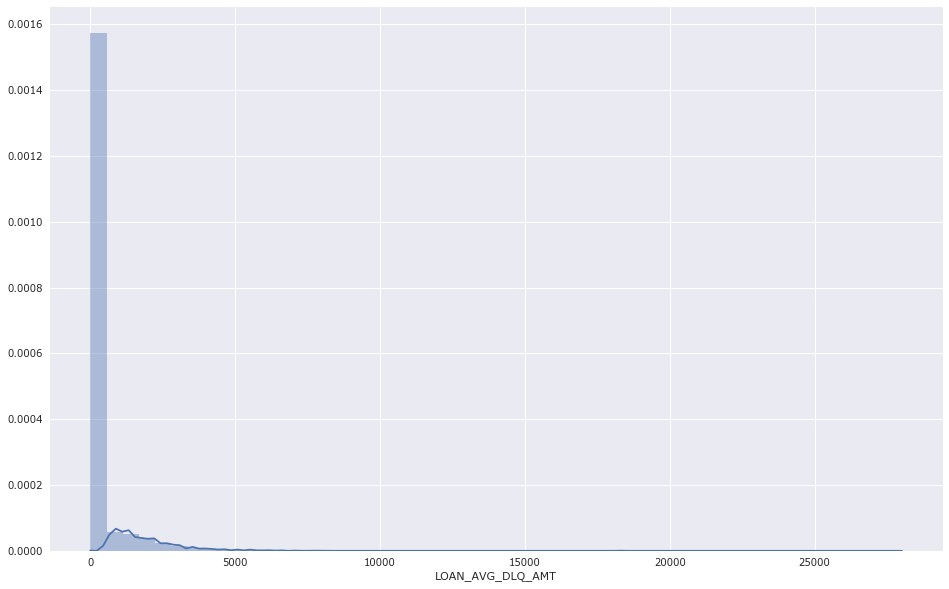

In [58]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[15]])

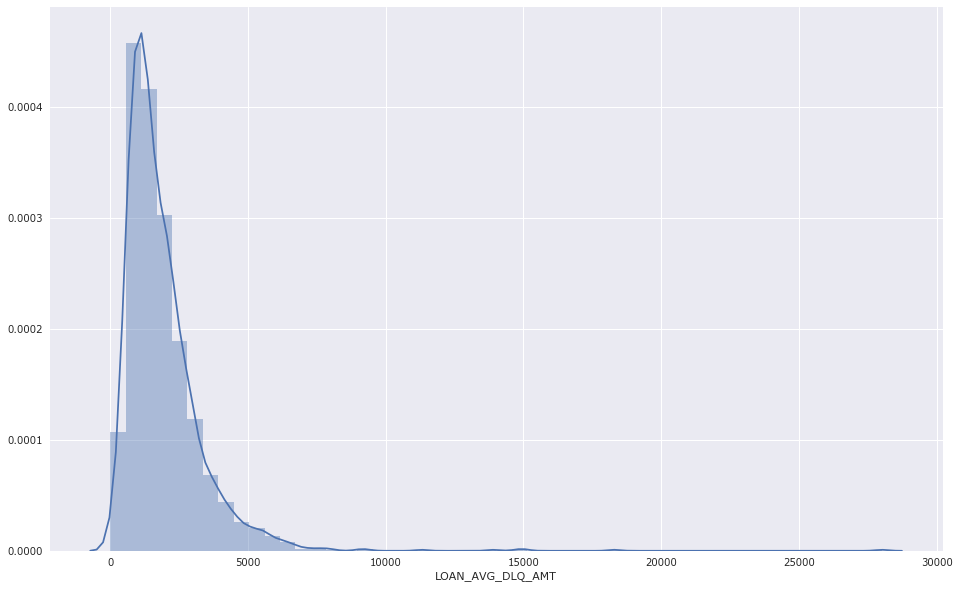

In [59]:
# без нуля
plt.subplots(figsize=(16, 10))

sns.distplot(data[data['LOAN_AVG_DLQ_AMT'] != 0]['LOAN_AVG_DLQ_AMT'])

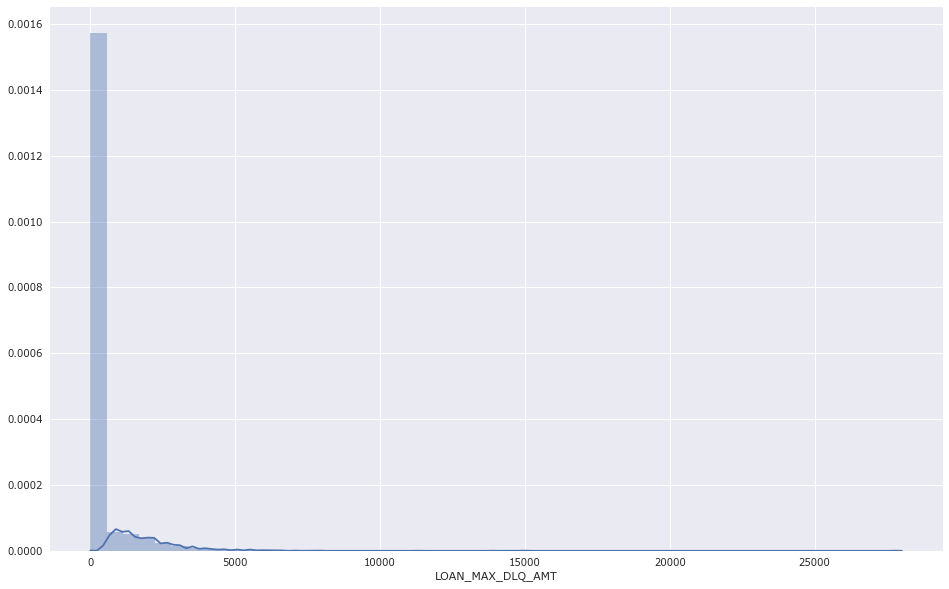

In [60]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[16]])

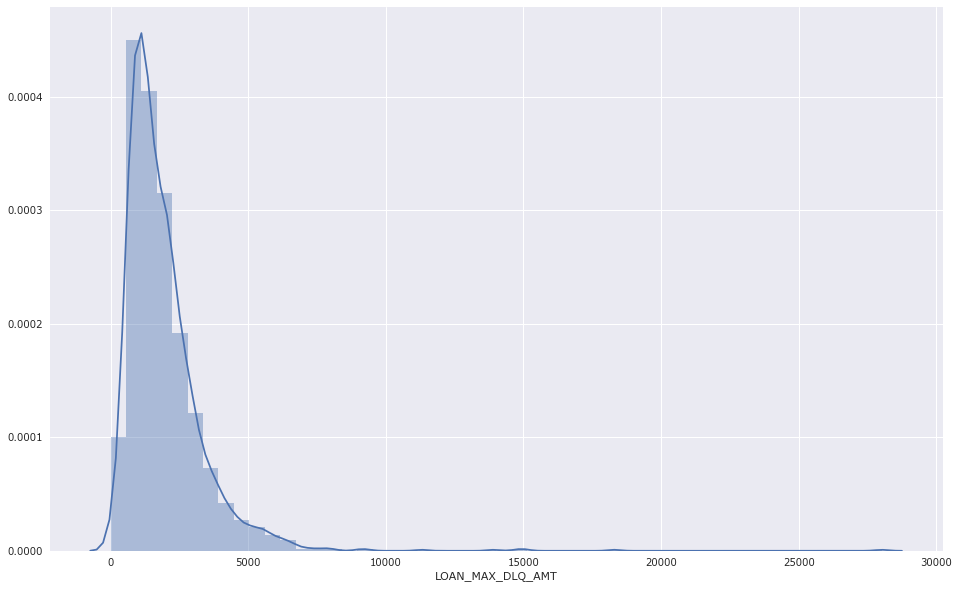

In [61]:
# без нуля
plt.subplots(figsize=(16, 10))

sns.distplot(data[data['LOAN_MAX_DLQ_AMT'] != 0]['LOAN_MAX_DLQ_AMT'])

## Бининг

In [62]:
cat_columns, num_columns = columns()

In [63]:
cols_enl = show_binning(categorical_columns=cat_columns)

Среднее специальное               6518
Среднее                           4679
Высшее                            3133
Неоконченное высшее                532
Неполное среднее                   340
Два и более высших образования      20
Ученая степень                       1
Name: EDUCATION, dtype: int64

Торговля                                     2385
Другие сферы                                 1709
nan                                          1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   

In [64]:
data[cols_enl[0]].value_counts()

Среднее специальное               6518
Среднее                           4679
Высшее                            3133
Неоконченное высшее                532
Неполное среднее                   340
Два и более высших образования      20
Ученая степень                       1
Name: EDUCATION, dtype: int64

In [65]:
data.at[data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
data.at[data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'

In [66]:
data[cols_enl[1]].value_counts()

Торговля                                     2385
Другие сферы                                 1709
nan                                          1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108


In [67]:
data.at[data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'СМИ/Реклама/PR-агенства'
small_categories_aggregation(column='GEN_INDUSTRY', n_samples=20, value='Другие сферы')
data[cols_enl[1]].value_counts()

Торговля                                     2385
Другие сферы                                 1756
nan                                          1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108


In [68]:
data[cols_enl[2]].value_counts()

Специалист                        7010
Рабочий                           3075
nan                               1367
Служащий                           904
Руководитель среднего звена        697
Работник сферы услуг               563
Высококвалифиц. специалист         549
Руководитель высшего звена         427
Индивидуальный предприниматель     217
Другое                             177
Руководитель низшего звена         136
Военнослужащий по контракту         88
Партнер                             13
Name: GEN_TITLE, dtype: int64

In [69]:
data[cols_enl[3]].value_counts()

Частная компания                  6523
Государственная комп./учреж.      6112
nan                               1367
Индивидуальный предприниматель     957
Некоммерческая организация         243
Частная ком. с инос. капиталом      21
Name: ORG_TP_STATE, dtype: int64

In [70]:
data.at[data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 'ORG_TP_STATE'] = 'Частная компания'

In [71]:
data[cols_enl[4]].value_counts()

Участие в основ. деятельности    11452
nan                               1367
Вспомогательный техперсонал       1025
Бухгалтерия, финансы, планир.      481
Адм-хоз. и трансп. службы          279
Снабжение и сбыт                   217
Служба безопасности                164
Кадровая служба и секретариат      101
Пр-техн. обесп. и телеком.          75
Юридическая служба                  53
Реклама и маркетинг                  9
Name: JOB_DIR, dtype: int64

In [128]:
data.at[data['JOB_DIR'] == 'Реклама и маркетинг', 'JOB_DIR'] = 'Юридическая служба'

In [72]:
data[cols_enl[5]].value_counts()

от 10000 до 20000 руб.    7077
от 20000 до 50000 руб.    6082
от 5000 до 10000 руб.     1512
свыше 50000 руб.           492
до 5000 руб.                60
Name: FAMILY_INCOME, dtype: int64

In [73]:
data[cols_enl[6]].value_counts()

Кемеровская область            674
Краснодарский край             674
Алтайский край                 459
Читинская область              426
Приморский край                416
Ростовская область             407
Свердловская область           349
Саратовская область            331
Волгоградская область          331
Воронежская область            301
Вологодская область            292
Челябинская область            292
Татарстан                      287
Омская область                 287
Кировская область              264
Архангельская область          257
Оренбургская область           253
Хабаровский край               252
Тульская область               252
Красноярский край              239
Самарская область              235
Башкирия                       222
Курская область                217
Белгородская область           215
Новосибирская область          214
Липецкая область               206
Иркутская область              202
Тюменская область              199
Бурятия             

In [74]:
data.at[data['REG_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['REG_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['REG_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['REG_ADDRESS_PROVINCE'] == 'Дагестан', 'REG_ADDRESS_PROVINCE'] = 'Северная Осетия'

In [75]:
data[cols_enl[7]].value_counts()

Кемеровская область            674
Краснодарский край             674
Алтайский край                 454
Читинская область              426
Приморский край                415
Ростовская область             404
Свердловская область           348
Волгоградская область          332
Саратовская область            324
Воронежская область            301
Челябинская область            292
Вологодская область            292
Татарстан                      286
Омская область                 286
Кировская область              266
Архангельская область          255
Хабаровский край               254
Оренбургская область           250
Тульская область               249
Самарская область              239
Красноярский край              237
Башкирия                       221
Новосибирская область          216
Белгородская область           214
Курская область                213
Московская область             207
Иркутская область              203
Липецкая область               202
Тюменская область   

In [76]:
data.at[data['FACT_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['FACT_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['FACT_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['FACT_ADDRESS_PROVINCE'] == 'Дагестан', 'FACT_ADDRESS_PROVINCE'] = 'Северная Осетия'

In [77]:
data[cols_enl[8]].value_counts()

Кемеровская область            674
Краснодарский край             674
Алтайский край                 456
Читинская область              426
Приморский край                415
Ростовская область             404
Свердловская область           348
Волгоградская область          331
Саратовская область            326
Воронежская область            302
Вологодская область            293
Челябинская область            292
Татарстан                      287
Омская область                 286
Кировская область              266
Архангельская область          255
Хабаровский край               254
Оренбургская область           251
Тульская область               249
Красноярский край              239
Самарская область              239
Башкирия                       221
Новосибирская область          215
Курская область                214
Белгородская область           212
Липецкая область               204
Московская область             203
Иркутская область              202
Тюменская область   

In [78]:
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Дагестан', 'POSTAL_ADDRESS_PROVINCE'] = 'Северная Осетия'

In [79]:
data[cols_enl[9]].value_counts()

Краснодарский край         790
Кемеровская область        668
Алтайский край             436
Приморский край            413
Читинская область          412
Ставропольский край        411
Ростовская область         405
Челябинская область        354
Свердловская область       340
Волгоградская область      339
Кировская область          333
Саратовская область        317
Воронежская область        312
Красноярский край          295
nan                        295
Вологодская область        292
Омская область             286
Татарстан                  272
Хабаровский край           258
Санкт-Петербург            254
Оренбургская область       251
Тульская область           245
Архангельская область      243
Новосибирская область      238
Самарская область          236
Амурская область           224
Курская область            212
Белгородская область       211
Бурятия                    211
Ярославская область        208
                          ... 
Пермская область           162
Чувашия 

In [80]:
# потому что соседи
data.at[data['TP_PROVINCE'] == 'Кабардино-Балкария', 'TP_PROVINCE'] = 'Ставропольский край'

In [81]:
data[cols_enl[10]].value_counts()

ЮЖНЫЙ                 2179
ЦЕНТРАЛЬНЫЙ 2         1934
ЗАПАДНО-СИБИРСКИЙ     1835
ЦЕНТРАЛЬНЫЙ 1         1653
ПОВОЛЖСКИЙ            1436
ПРИВОЛЖСКИЙ           1270
ВОСТОЧНО-СИБИРСКИЙ    1256
УРАЛЬСКИЙ             1195
ДАЛЬНЕВОСТОЧНЫЙ       1141
СЕВЕРО-ЗАПАДНЫЙ       1028
ЦЕНТРАЛЬНЫЙ ОФИС       295
nan                      1
Name: REGION_NM, dtype: int64

In [82]:
data.at[data['REGION_NM'] == 'nan', 'REGION_NM'] = 'ЮЖНЫЙ'

In [83]:
data[cols_enl[11]].value_counts()

0    15074
1      149
Name: COT_PRESENCE_FL, dtype: int64

## Добавление фичей

In [85]:
data['SOLVENCY'] = (data['CREDIT']/data['TERM'])/data['PERSONAL_INCOME']

In [86]:
# просрачивал ли клиент когда-либо оплату кредита
data['DELAY'] = '0'
data.at[data['LOAN_DLQ_NUM'] == 0, 'DELAY'] = '0'
data.at[data['LOAN_DLQ_NUM'] > 0, 'DELAY'] = '1'
data['DELAY'].value_counts()

0    13301
1     1922
Name: DELAY, dtype: int64

In [87]:
cat_columns, num_columns = columns()

In [88]:
for i in cat_columns:
    if len(data[i].value_counts()) > 15:
        print(data[i].value_counts())
        print()

Торговля                                     2385
Другие сферы                                 1756
nan                                          1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108


In [89]:
data['REG_ADDRESS_PROVINCE'] = data['REG_ADDRESS_PROVINCE'].map(data['REG_ADDRESS_PROVINCE'].value_counts())
data['FACT_ADDRESS_PROVINCE'] = data['FACT_ADDRESS_PROVINCE'].map(data['FACT_ADDRESS_PROVINCE'].value_counts())
data['POSTAL_ADDRESS_PROVINCE'] = data['POSTAL_ADDRESS_PROVINCE'].map(data['POSTAL_ADDRESS_PROVINCE'].value_counts())
data['TP_PROVINCE'] = data['TP_PROVINCE'].map(data['TP_PROVINCE'].value_counts())

## Обработка численных полей

In [90]:
columns_to_category = ['CHILD_TOTAL', 'DEPENDANTS', 'OWN_AUTO', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED', 'LOAN_DLQ_NUM']

In [91]:
data.drop('LOAN_MAX_DLQ', axis=1, inplace=True)

In [92]:
# переводим в категориальные значения
for i in columns_to_category:
    if i in data.columns:
        data[i]=data[i].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 51 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null object
DEPENDANTS                    15223 non-null object
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRESS_PROVINCE          15223 non-null int64
FACT_ADD

In [93]:
for col in columns_to_category:
    print(data[col].value_counts())
    print()

1     5087
0     4984
2     4140
3      799
4      133
5       59
6       12
7        5
10       3
8        1
Name: CHILD_TOTAL, dtype: int64

0    8226
1    4535
2    2167
3     243
4      42
5       5
6       4
7       1
Name: DEPENDANTS, dtype: int64

0    13453
1     1769
2        1
Name: OWN_AUTO, dtype: int64

1     11288
2      2633
3       871
4       275
5       102
6        36
7        14
8         3
11        1
Name: LOAN_NUM_TOTAL, dtype: int64

0     7791
1     4761
2     1770
3      603
4      202
5       62
6       26
7        5
8        2
11       1
Name: LOAN_NUM_CLOSED, dtype: int64

0     13301
1      1416
2       280
3        96
4        48
5        39
6        16
7        14
9         4
8         3
10        2
13        2
12        1
11        1
Name: LOAN_DLQ_NUM, dtype: int64



In [94]:
data.at[data['CHILD_TOTAL'] == '5', 'CHILD_TOTAL'] = '4'
data.at[data['CHILD_TOTAL'] == '6', 'CHILD_TOTAL'] = '4'
data.at[data['CHILD_TOTAL'] == '7', 'CHILD_TOTAL'] = '4'
data.at[data['CHILD_TOTAL'] == '10', 'CHILD_TOTAL'] = '4'
data.at[data['CHILD_TOTAL'] == '8', 'CHILD_TOTAL'] = '4'

In [95]:
data.at[data['DEPENDANTS'] == '5', 'DEPENDANTS'] = '4'
data.at[data['DEPENDANTS'] == '6', 'DEPENDANTS'] = '4'
data.at[data['DEPENDANTS'] == '7', 'DEPENDANTS'] = '4'

In [96]:
data.at[data['OWN_AUTO'] == '2', 'OWN_AUTO'] = '1'

In [97]:
data.at[data['LOAN_NUM_TOTAL'] == '8', 'LOAN_NUM_TOTAL'] = '7'
data.at[data['LOAN_NUM_TOTAL'] == '11', 'LOAN_NUM_TOTAL'] = '7'

In [98]:
data.at[data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'

In [99]:
data.at[data['LOAN_DLQ_NUM'] == '9', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '8', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '10', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '13', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '11', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '12', 'LOAN_DLQ_NUM'] = '7'

In [100]:
cats, nums = columns()

In [101]:
data.describe()

,AGE,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_PAYM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,SOLVENCY
count,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000
mean,40.4061,13853.8363,270.7468,269.9668,270.2251,295.1775,14667.9593,8.1010,3398.5627,131.0020,75.5412,7.8760,239.4571,243.0216,0.0191,0.1683
std,11.6011,9015.4676,157.6221,157.3229,157.3993,172.4570,12147.8735,4.0941,5158.1089,107.6183,89.5994,7.9557,827.7004,836.1001,0.1377,1.1911
min,21.0000,24.0000,22.0000,22.0000,22.0000,19.0000,2000.0000,3.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0058
25%,30.0000,8000.0000,167.0000,165.0000,166.0000,164.0000,6500.0000,6.0000,1000.0000,41.0000,14.0000,4.0000,0.0000,0.0000,0.0000,0.0846
50%,39.0000,12000.0000,217.0000,216.0000,215.0000,251.0000,11550.0000,6.0000,2000.0000,107.0000,40.0000,5.0000,0.0000,0.0000,0.0000,0.1325
75%,50.0000,17000.0000,331.0000,324.0000,326.0000,354.0000,19170.0000,10.0000,4000.0000,204.0000,96.0000,8.0000,0.0000,0.0000,0.0000,0.2027
max,67.0000,250000.0000,674.0000,674.0000,674.0000,790.0000,119700.0000,36.0000,140000.0000,696.0000,516.0000,114.0000,28012.2000,28012.2000,2.0000,146.5417


In [102]:
data[cats].describe()

,TARGET,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,GPF_DOCUMENT_FL,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,DELAY
count,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223
unique,2,2,2,2,5,5,5,5,27,13,5,3,11,5,11,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,7,8,8,2
top,0,1,0,1,1,0,Среднее специальное,Состою в браке,Торговля,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,ЮЖНЫЙ,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0
freq,13411,13847,13176,9964,5087,8226,6518,9416,2385,7010,6544,13688,11452,7077,2180,12765,14480,13493,12758,13782,10507,13453,14097,11940,15074,14930,14558,8961,9311,14389,13855,11288,7791,13301,13301


In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 51 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null object
DEPENDANTS                    15223 non-null object
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRESS_PROVINCE          15223 non-null int64
FACT_ADD

In [104]:
dummy_data = pd.get_dummies(data)

# Data Processing Tool
[Вернуться к быстрому перемещению](#Быстрое-перемещение)

## Первая версия

In [11]:
def process_data(data):

    # указано в условии
    data['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0, inplace=True)
    
    # удаляем id
    data.drop('AGREEMENT_RK', axis=1, inplace=True)
    
    # одно уникальное значение
    data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)
    
    categorical_columns = ['TARGET', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'GENDER', 'EDUCATION', 'MARITAL_STATUS',
                           'GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR',
                           'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE',
                           'REGION_NM', 'REG_FACT_FL', 'FACT_POST_FL', 'REG_POST_FL', 'REG_FACT_POST_FL',
                           'REG_FACT_POST_TP_FL', 'FL_PRESENCE_FL', 'AUTO_RUS_FL', 'HS_PRESENCE_FL',
                           'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL', 'DL_DOCUMENT_FL',
                           'GPF_DOCUMENT_FL', 'FACT_PHONE_FL', 'REG_PHONE_FL', 'GEN_PHONE_FL', 
                           'PREVIOUS_CARD_NUM_UTILIZED']
    
    for i in categorical_columns:
        if i in data.columns:
            data[i] = data[i].astype('str')
    
    # если человек нигде не работает, то WORK_TIME = 0
    data.at[(data['GEN_INDUSTRY'] == 'nan') & (data['GEN_TITLE'] == 'nan'), 'WORK_TIME'] = 0
    
    # максимальное значение, после которого значения считаются "неправильными"
    maxy_work_time = max(data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time])
    
    # считаем значения больше maxy_work_time - пропущенными
    data.at[data['WORK_TIME'] > maxy_work_time, 'WORK_TIME'] = np.NaN
    
    true_median = data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()
    data['WORK_TIME'].fillna(true_median, inplace=True)
    
    data.at[data['FACT_LIVING_TERM'] < 0, 'FACT_LIVING_TERM'] = 0
    
    maxy_live_term = max(data['FACT_LIVING_TERM'].sort_values()[:heu_const_work_time])
    
    # считаем значения больше maxy_work_time - пропущенными
    data.at[data['FACT_LIVING_TERM'] > maxy_live_term, 'FACT_LIVING_TERM'] = np.NaN
    
    true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()
    
    true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[
                            :heu_const_work_time].median()
    data['FACT_LIVING_TERM'].fillna(true_median, inplace=True)
    
    for i in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
        if i in data.columns:
            data[i] = data[i].str.replace(',', '.').astype('float')
    
    cat_columns, num_columns = columns()
    
    data.at[data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
    data.at[data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'
    
    data.at[data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'СМИ/Реклама/PR-агенства'
    small_categories_aggregation(column='GEN_INDUSTRY', n_samples=20, value='Другие сферы')
    
    data.at[data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 'ORG_TP_STATE'] = 'Частная компания'
    
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Дагестан', 'REG_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Дагестан', 'FACT_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[
        data['POSTAL_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Дагестан', 'POSTAL_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    # потому что соседи
    data.at[data['TP_PROVINCE'] == 'Кабардино-Балкария', 'TP_PROVINCE'] = 'Ставропольский край'
    
    data.at[data['REGION_NM'] == 'nan', 'REGION_NM'] = 'ЮЖНЫЙ'
    
    # просрачивал ли клиент когда-либо оплату кредита
    data['DELAY'] = '0'
    data.at[data['LOAN_DLQ_NUM'] == 0, 'DELAY'] = '0'
    data.at[data['LOAN_DLQ_NUM'] > 0, 'DELAY'] = '1'
    
    cat_columns, num_columns = columns()
    
    data['REG_ADDRESS_PROVINCE'] = data['REG_ADDRESS_PROVINCE'].map(data['REG_ADDRESS_PROVINCE'].value_counts())
    data['FACT_ADDRESS_PROVINCE'] = data['FACT_ADDRESS_PROVINCE'].map(data['FACT_ADDRESS_PROVINCE'].value_counts())
    data['POSTAL_ADDRESS_PROVINCE'] = data['POSTAL_ADDRESS_PROVINCE'].map(data['POSTAL_ADDRESS_PROVINCE'].value_counts())
    data['TP_PROVINCE'] = data['TP_PROVINCE'].map(data['TP_PROVINCE'].value_counts())
    
    columns_to_category = ['CHILD_TOTAL', 'DEPENDANTS', 'OWN_AUTO', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED', 'LOAN_DLQ_NUM']
    
    data.drop('LOAN_MAX_DLQ', axis=1, inplace=True)
    
    # переводим в категориальные значения
    for i in columns_to_category:
        if i in data.columns:
            data[i] = data[i].astype('str')
    
    data.at[data['CHILD_TOTAL'] == '5', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '6', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '7', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '10', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '8', 'CHILD_TOTAL'] = '4'
    
    data.at[data['DEPENDANTS'] == '5', 'DEPENDANTS'] = '4'
    data.at[data['DEPENDANTS'] == '6', 'DEPENDANTS'] = '4'
    data.at[data['DEPENDANTS'] == '7', 'DEPENDANTS'] = '4'
    
    data.at[data['OWN_AUTO'] == '2', 'OWN_AUTO'] = '1'
    
    data.at[data['LOAN_NUM_TOTAL'] == '8', 'LOAN_NUM_TOTAL'] = '7'
    data.at[data['LOAN_NUM_TOTAL'] == '11', 'LOAN_NUM_TOTAL'] = '7'
    
    data.at[data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    
    data.at[data['LOAN_NUM_CLOSED'] == '9', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '10', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '13', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    
    cats, nums = columns()
    
    return pd.get_dummies(data), data, cats, nums

## Вторая версия

In [183]:
def process_data():
    
    pre_data = pd.read_csv("data/Credit_OTP.csv", encoding='cp1251', sep=';')

    pre_data = pre_data.reindex(np.random.permutation(pre_data.index))
    
    data = pre_data[:int(len(pre_data)*0.7)]
    test_data = pre_data[int(len(pre_data)*0.7):]
    
    categorical_columns = ['TARGET', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'GENDER', 'EDUCATION', 'MARITAL_STATUS',
                           'GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR',
                           'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE',
                           'REGION_NM', 'REG_FACT_FL', 'FACT_POST_FL', 'REG_POST_FL', 'REG_FACT_POST_FL',
                           'REG_FACT_POST_TP_FL', 'FL_PRESENCE_FL', 'AUTO_RUS_FL', 'HS_PRESENCE_FL',
                           'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL', 'DL_DOCUMENT_FL',
                           'GPF_DOCUMENT_FL', 'FACT_PHONE_FL', 'REG_PHONE_FL', 'GEN_PHONE_FL', 
                           'PREVIOUS_CARD_NUM_UTILIZED']        

    # указано в условии
    data['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0, inplace=True)
    test_data['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0, inplace=True)
    
    # удаляем id
    data.drop('AGREEMENT_RK', axis=1, inplace=True)
    test_data.drop('AGREEMENT_RK', axis=1, inplace=True)
    
    # одно уникальное значение
    data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)
    test_data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)

    
    for i in categorical_columns:
        if i in data.columns:
            data[i] = data[i].astype('str')
            test_data[i] = test_data[i].astype('str')
    
    
    # если человек нигде не работает, то WORK_TIME = 0
    data.at[(data['GEN_INDUSTRY'] == 'nan') & (data['GEN_TITLE'] == 'nan'), 'WORK_TIME'] = 0
    test_data.at[(test_data['GEN_INDUSTRY'] == 'nan') & (data['GEN_TITLE'] == 'nan'), 'WORK_TIME'] = 0
    
    # эспериментально выбранное значение
    heu_const_work_time = 15200
    true_median = data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()
    true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()
    
    # максимальное значение, после которого значения считаются "неправильными"
    maxy_work_time = max(data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time])
    
    # считаем значения больше maxy_work_time - пропущенными
    data.at[data['WORK_TIME'] > maxy_work_time, 'WORK_TIME'] = np.NaN
    
    try:
        test_data.at[data['WORK_TIME'] > maxy_work_time, 'WORK_TIME'] = np.NaN
    except:
        pass
    
    true_median_work_time = data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()
    data['WORK_TIME'].fillna(true_median_work_time, inplace=True)
    test_data['WORK_TIME'].fillna(true_median_work_time, inplace=True)
    
    data.at[data['FACT_LIVING_TERM'] < 0, 'FACT_LIVING_TERM'] = 0
    test_data.at[test_data['FACT_LIVING_TERM'] < 0, 'FACT_LIVING_TERM'] = 0
    
    maxy_live_term = max(data['FACT_LIVING_TERM'].sort_values()[:heu_const_work_time])
    
    # считаем значения больше maxy_work_time - пропущенными
    data.at[data['FACT_LIVING_TERM'] > maxy_live_term, 'FACT_LIVING_TERM'] = np.NaN
    test_data.at[test_data['FACT_LIVING_TERM'] > maxy_live_term, 'FACT_LIVING_TERM'] = np.NaN
    
    true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()
    data['FACT_LIVING_TERM'].fillna(true_median, inplace=True)
    test_data['FACT_LIVING_TERM'].fillna(true_median, inplace=True)
    
    for i in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
        if i in data.columns:
            data[i] = data[i].str.replace(',', '.').astype('float')
            test_data[i] = test_data[i].str.replace(',', '.').astype('float')
    
    cat_columns, num_columns = columns()
    
    data.at[data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
    data.at[data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'
    test_data.at[test_data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
    test_data.at[test_data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'
    
    
    data.at[data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'СМИ/Реклама/PR-агенства'
    test_data.at[test_data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'СМИ/Реклама/PR-агенства'
    
    tmp_small_columns = data['GEN_INDUSTRY'].value_counts()[data['GEN_INDUSTRY'].value_counts() < 20].index

    for col in tmp_small_columns:
        data.at[data['GEN_INDUSTRY'] == col, 'GEN_INDUSTRY'] = 'Другие сферы'
        test_data.at[test_data['GEN_INDUSTRY'] == col, 'GEN_INDUSTRY'] = 'Другие сферы'
    
    
    data.at[data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 'ORG_TP_STATE'] = 'Частная компания'
    test_data.at[test_data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 'ORG_TP_STATE'] = 'Частная компания'
    
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Дагестан', 'REG_ADDRESS_PROVINCE'] = 'Северная Осетия'
    test_data.at[test_data['REG_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['REG_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['REG_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['REG_ADDRESS_PROVINCE'] == 'Дагестан', 'REG_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Дагестан', 'FACT_ADDRESS_PROVINCE'] = 'Северная Осетия'
    test_data.at[test_data['FACT_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['FACT_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['FACT_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['FACT_ADDRESS_PROVINCE'] == 'Дагестан', 'FACT_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Дагестан', 'POSTAL_ADDRESS_PROVINCE'] = 'Северная Осетия'
    test_data.at[test_data['POSTAL_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['POSTAL_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['POSTAL_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['POSTAL_ADDRESS_PROVINCE'] == 'Дагестан', 'POSTAL_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    # потому что соседи
    data.at[data['TP_PROVINCE'] == 'Кабардино-Балкария', 'TP_PROVINCE'] = 'Ставропольский край'
    test_data.at[test_data['TP_PROVINCE'] == 'Кабардино-Балкария', 'TP_PROVINCE'] = 'Ставропольский край'
    
    data.at[data['REGION_NM'] == 'nan', 'REGION_NM'] = 'ЮЖНЫЙ'
    test_data.at[test_data['REGION_NM'] == 'nan', 'REGION_NM'] = 'ЮЖНЫЙ'
    
    # просрачивал ли клиент когда-либо оплату кредита
    data['DELAY'] = '0'
    data.at[data['LOAN_DLQ_NUM'] == 0, 'DELAY'] = '0'
    data.at[data['LOAN_DLQ_NUM'] > 0, 'DELAY'] = '1'
    test_data['DELAY'] = '0'
    test_data.at[test_data['LOAN_DLQ_NUM'] == 0, 'DELAY'] = '0'
    test_data.at[test_data['LOAN_DLQ_NUM'] > 0, 'DELAY'] = '1'
    
    cat_columns, num_columns = columns()
    
    tmp_data = data.copy()
    
    data['REG_ADDRESS_PROVINCE'] = data['REG_ADDRESS_PROVINCE'].map(data['REG_ADDRESS_PROVINCE'].value_counts())
    data['FACT_ADDRESS_PROVINCE'] = data['FACT_ADDRESS_PROVINCE'].map(data['FACT_ADDRESS_PROVINCE'].value_counts())
    data['POSTAL_ADDRESS_PROVINCE'] = data['POSTAL_ADDRESS_PROVINCE'].map(data['POSTAL_ADDRESS_PROVINCE'].value_counts())
    data['TP_PROVINCE'] = data['TP_PROVINCE'].map(data['TP_PROVINCE'].value_counts())
    
    test_data_freq_func_reg = lambda x: DataFrame(tmp_data['REG_ADDRESS_PROVINCE'].value_counts()).loc[x, 'REG_ADDRESS_PROVINCE']
    test_data_freq_func_fact = lambda x: DataFrame(tmp_data['FACT_ADDRESS_PROVINCE'].value_counts()).loc[x, 'FACT_ADDRESS_PROVINCE']
    test_data_freq_func_postal = lambda x: DataFrame(tmp_data['POSTAL_ADDRESS_PROVINCE'].value_counts()).loc[x, 'POSTAL_ADDRESS_PROVINCE']
    test_data_freq_func_tp = lambda x: DataFrame(tmp_data['TP_PROVINCE'].value_counts()).loc[x, 'TP_PROVINCE']

    test_data['REG_ADDRESS_PROVINCE'] = test_data['REG_ADDRESS_PROVINCE'].map(test_data_freq_func_reg)
    test_data['FACT_ADDRESS_PROVINCE'] = test_data['FACT_ADDRESS_PROVINCE'].map(test_data_freq_func_fact)
    test_data['POSTAL_ADDRESS_PROVINCE'] = test_data['POSTAL_ADDRESS_PROVINCE'].map(test_data_freq_func_postal)
    test_data['TP_PROVINCE'] = test_data['TP_PROVINCE'].map(test_data_freq_func_tp)
    
    data.at[data['JOB_DIR'] == 'Реклама и маркетинг', 'JOB_DIR'] = 'Юридическая служба'
    test_data.at[test_data['JOB_DIR'] == 'Реклама и маркетинг', 'JOB_DIR'] = 'Юридическая служба'
    
    columns_to_category = ['CHILD_TOTAL', 'DEPENDANTS', 'OWN_AUTO', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED',
                           'LOAN_DLQ_NUM']
    
    data.drop('LOAN_MAX_DLQ', axis=1, inplace=True)
    test_data.drop('LOAN_MAX_DLQ', axis=1, inplace=True)
    
    # переводим в категориальные значения
    for i in columns_to_category:
        if i in data.columns:
            data[i] = data[i].astype('str')
            test_data[i] = test_data[i].astype('str')  
    
    data.at[data['PREVIOUS_CARD_NUM_UTILIZED'] == '2.0', 'PREVIOUS_CARD_NUM_UTILIZED'] = '1.0'
    test_data.at[test_data['PREVIOUS_CARD_NUM_UTILIZED'] == '2.0', 'PREVIOUS_CARD_NUM_UTILIZED'] = '1.0'
    
    data.at[data['CHILD_TOTAL'] == '5', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '6', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '7', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '10', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '8', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '5', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '6', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '7', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '10', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '8', 'CHILD_TOTAL'] = '4'
    
    data.at[data['DEPENDANTS'] == '5', 'DEPENDANTS'] = '4'
    data.at[data['DEPENDANTS'] == '6', 'DEPENDANTS'] = '4'
    data.at[data['DEPENDANTS'] == '7', 'DEPENDANTS'] = '4'    
    test_data.at[test_data['DEPENDANTS'] == '5', 'DEPENDANTS'] = '4'
    test_data.at[test_data['DEPENDANTS'] == '6', 'DEPENDANTS'] = '4'
    test_data.at[test_data['DEPENDANTS'] == '7', 'DEPENDANTS'] = '4'
    
    data.at[data['OWN_AUTO'] == '2', 'OWN_AUTO'] = '1'
    test_data.at[test_data['OWN_AUTO'] == '2', 'OWN_AUTO'] = '1'
    
    data.at[data['LOAN_NUM_TOTAL'] == '8', 'LOAN_NUM_TOTAL'] = '7'
    data.at[data['LOAN_NUM_TOTAL'] == '11', 'LOAN_NUM_TOTAL'] = '7'
    test_data.at[test_data['LOAN_NUM_TOTAL'] == '8', 'LOAN_NUM_TOTAL'] = '7'
    test_data.at[test_data['LOAN_NUM_TOTAL'] == '11', 'LOAN_NUM_TOTAL'] = '7'
    
#     data.at[data['LOAN_NUM_CLOSED'] == '7', 'LOAN_NUM_CLOSED'] = '6'
    data.at[data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
#     test_data.at[test_data['LOAN_NUM_CLOSED'] == '7', 'LOAN_NUM_CLOSED'] = '6'
    test_data.at[test_data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
    test_data.at[test_data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    
#     data.drop('LOAN_NUM_CLOSED', axis=1, inplace=True)
#     test_data.drop('LOAN_NUM_CLOSED', axis=1, inplace=True)
    
    data.at[data['LOAN_DLQ_NUM'] == '9', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '8', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '10', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '13', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '11', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '12', 'LOAN_DLQ_NUM'] = '7'
    
    test_data.at[test_data['LOAN_DLQ_NUM'] == '9', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '8', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '10', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '13', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '11', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '12', 'LOAN_DLQ_NUM'] = '7'
    
#     aggr_cols = ['AUTO_RUS_FL', 'HS_PRESENCE_FL', 'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL']
    
#     for i in aggr_cols:
        
#         data['AGGR_COLS'] = 0
#         test_data['AGGR_COLS'] = 0
        
#         data['AGGR_COLS'] += data[i].astype('int32')
#         test_data['AGGR_COLS'] += test_data[i].astype('int32')
        
#         data.drop(i, axis=1, inplace=True)
#         test_data.drop(i, axis=1, inplace=True)
    
    data['SOLVENCY'] = (data['CREDIT']/data['TERM'])/data['PERSONAL_INCOME']
    test_data['SOLVENCY'] = (test_data['CREDIT']/test_data['TERM'])/test_data['PERSONAL_INCOME']
    
    data.at[data['SOLVENCY'] > 100, 'SOLVENCY'] = data[data['SOLVENCY'] < 100]['SOLVENCY'].median()
    test_data.at[test_data['SOLVENCY'] > 100, 'SOLVENCY'] = test_data[test_data['SOLVENCY'] < 100]['SOLVENCY'].median()

    
#     data['PERCENT_FIRST_PAYMENT'] = data['FST_PAYMENT']/data['PERSONAL_INCOME']
#     test_data['PERCENT_FIRST_PAYMENT'] = test_data['FST_PAYMENT']/test_data['PERSONAL_INCOME']
    
    cats, nums = columns()
    
    dummy_train = pd.get_dummies(data)
    dummy_test = pd.get_dummies(test_data)
    
    return dummy_train, data, dummy_test, test_data, cats, nums

In [184]:
train_dummy, train_data, test_dummy, test_data, cats, nums = process_data()

In [185]:
train_dummy.head()

,AGE,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_PAYM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,SOLVENCY,TARGET_0,TARGET_1,SOCSTATUS_WORK_FL_0,SOCSTATUS_WORK_FL_1,SOCSTATUS_PENS_FL_0,SOCSTATUS_PENS_FL_1,GENDER_0,GENDER_1,CHILD_TOTAL_0,CHILD_TOTAL_1,CHILD_TOTAL_2,CHILD_TOTAL_3,CHILD_TOTAL_4,DEPENDANTS_0,DEPENDANTS_1,...,REG_PHONE_FL_1,GEN_PHONE_FL_0,GEN_PHONE_FL_1,LOAN_NUM_TOTAL_1,LOAN_NUM_TOTAL_2,LOAN_NUM_TOTAL_3,LOAN_NUM_TOTAL_4,LOAN_NUM_TOTAL_5,LOAN_NUM_TOTAL_6,LOAN_NUM_TOTAL_7,LOAN_NUM_CLOSED_0,LOAN_NUM_CLOSED_1,LOAN_NUM_CLOSED_2,LOAN_NUM_CLOSED_3,LOAN_NUM_CLOSED_4,LOAN_NUM_CLOSED_5,LOAN_NUM_CLOSED_6,LOAN_NUM_CLOSED_7,LOAN_DLQ_NUM_0,LOAN_DLQ_NUM_1,LOAN_DLQ_NUM_2,LOAN_DLQ_NUM_3,LOAN_DLQ_NUM_4,LOAN_DLQ_NUM_5,LOAN_DLQ_NUM_6,LOAN_DLQ_NUM_7,PREVIOUS_CARD_NUM_UTILIZED_0.0,PREVIOUS_CARD_NUM_UTILIZED_1.0,DELAY_0,DELAY_1
2648,41,9000.0000,91,89,90,89,11300.0000,12,1500.0000,195.0000,96.0000,6,0.0000,0.0000,0.1046,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
10091,56,17000.0000,131,134,133,140,18000.0000,4,5000.0000,60.0000,108.0000,10,0.0000,0.0000,0.2647,1,0,0,1,1,0,0,1,0,1,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
4835,32,27000.0000,461,461,461,457,21989.0000,12,15091.0000,48.0000,13.0000,5,0.0000,0.0000,0.0679,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
13945,59,18000.0000,110,110,110,110,9900.0000,5,2062.5000,19.0000,229.0000,16,0.0000,0.0000,0.1100,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
7668,21,25000.0000,216,215,216,215,7590.0000,9,3000.0000,240.0000,48.0000,4,0.0000,0.0000,0.0337,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [186]:
test_dummy.head()

,AGE,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_PAYM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,SOLVENCY,TARGET_0,TARGET_1,SOCSTATUS_WORK_FL_0,SOCSTATUS_WORK_FL_1,SOCSTATUS_PENS_FL_0,SOCSTATUS_PENS_FL_1,GENDER_0,GENDER_1,CHILD_TOTAL_0,CHILD_TOTAL_1,CHILD_TOTAL_2,CHILD_TOTAL_3,CHILD_TOTAL_4,DEPENDANTS_0,DEPENDANTS_1,...,REG_PHONE_FL_1,GEN_PHONE_FL_0,GEN_PHONE_FL_1,LOAN_NUM_TOTAL_1,LOAN_NUM_TOTAL_2,LOAN_NUM_TOTAL_3,LOAN_NUM_TOTAL_4,LOAN_NUM_TOTAL_5,LOAN_NUM_TOTAL_6,LOAN_NUM_TOTAL_7,LOAN_NUM_CLOSED_0,LOAN_NUM_CLOSED_1,LOAN_NUM_CLOSED_2,LOAN_NUM_CLOSED_3,LOAN_NUM_CLOSED_4,LOAN_NUM_CLOSED_5,LOAN_NUM_CLOSED_6,LOAN_NUM_CLOSED_7,LOAN_DLQ_NUM_0,LOAN_DLQ_NUM_1,LOAN_DLQ_NUM_2,LOAN_DLQ_NUM_3,LOAN_DLQ_NUM_4,LOAN_DLQ_NUM_5,LOAN_DLQ_NUM_6,LOAN_DLQ_NUM_7,PREVIOUS_CARD_NUM_UTILIZED_0.0,PREVIOUS_CARD_NUM_UTILIZED_1.0,DELAY_0,DELAY_1
7040,43,20000.0000,71,68,68,296,8970.0000,6,0.0000,48.0000,120.0000,4,0.0000,0.0000,0.0747,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
12577,39,10000.0000,172,170,172,212,5590.0000,12,0.0000,31.0000,9.0000,3,630.0000,630.0000,0.0466,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
11114,29,5400.0000,71,68,68,296,13351.0000,6,2300.0000,204.0000,60.0000,5,0.0000,0.0000,0.4121,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2975,58,7000.0000,133,133,133,231,13720.0000,6,2080.0000,36.0000,48.0000,5,0.0000,0.0000,0.3267,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
12632,32,15000.0000,136,136,136,149,5525.0000,6,615.0000,96.0000,144.0000,4,0.0000,0.0000,0.0614,1,0,0,1,1,0,0,1,0,1,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [187]:
len(train_data), len(test_data)

(10656, 4567)

In [188]:
train_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10656 entries, 2648 to 14963
Columns: 175 entries, AGE to DELAY_1
dtypes: float64(8), int64(7), uint8(160)
memory usage: 3.2 MB


In [189]:
test_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4567 entries, 7040 to 7831
Columns: 175 entries, AGE to DELAY_1
dtypes: float64(8), int64(7), uint8(160)
memory usage: 1.4 MB


In [190]:
for i in test_dummy.columns:
    if i not in list(train_dummy.columns):
        print(i)

In [191]:
Xtrain, Xtest, ytrain, ytest = train_test_split(train_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1),
                                                train_dummy.loc[:, 'TARGET_1'], test_size=0.3)

## Построение RF без подгонки параметров

In [192]:
forest = RandomForestClassifier(n_estimators=250, max_depth=9, max_features=15, n_jobs=-1, random_state=42)
forest.fit(Xtrain, ytrain)
roc_auc_score(ytest, forest.predict_proba(Xtest)[:, 1])

0.68530988583105623

In [193]:
X = test_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1)
y = test_dummy.loc[:, 'TARGET_1']

In [194]:
for i in Xtrain.columns:
    if i not in list(X.columns):
        print(i)

In [195]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7459 entries, 2396 to 3614
Columns: 173 entries, AGE to DELAY_1
dtypes: float64(8), int64(7), uint8(158)
memory usage: 2.0 MB


In [196]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4567 entries, 7040 to 7831
Columns: 173 entries, AGE to DELAY_1
dtypes: float64(8), int64(7), uint8(158)
memory usage: 1.4 MB


In [197]:
roc_auc_score(y, forest.predict_proba(X)[:, 1])

0.68685821350286957

# Построение моделей
[Вернуться к быстрому перемещению](#Быстрое-перемещение)

In [228]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)

In [232]:
# Отключаем предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# Создаем экземляр класса StratifiedKFold 
strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения правильности на обучающей и контрольной выборках
train_auc = []
test_auc = []

trees_grid = [5, 10, 25, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# Строим модели с разным количеством деревьев
for ntrees in trees_grid:
    rf = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1)
    temp_train_acc = []
    temp_test_acc = []
    rf.fit(Xtrain, ytrain)
    print('N Trees', ntrees)
    print(roc_auc_score(ytrain, rf.predict_proba(Xtrain)[:, 1]))
    print(roc_auc_score(ytest, rf.predict_proba(Xtest)[:, 1]))
    print()
    train_auc.append(roc_auc_score(ytrain, rf.predict_proba(Xtrain)[:, 1]))
    test_auc.append(roc_auc_score(ytest, rf.predict_proba(Xtest)[:, 1]))

# Преобразуем списки в массивы NumPy
# train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)

N Trees 5
0.994859251228
0.547324604018

N Trees 10
0.999658661857
0.594532085976

N Trees 25
0.999999304987
0.623493591555

N Trees 50
1.0
0.640601159736

N Trees 100
1.0
0.650998590889

N Trees 150
1.0
0.664483122574

N Trees 200
1.0
0.667710587287

N Trees 250
1.0
0.66885628713

N Trees 300
1.0
0.670013835898

N Trees 350
1.0
0.67281109351

N Trees 400
1.0
0.672013569753

N Trees 450
1.0
0.671800289114

N Trees 500
1.0
0.672066434185



In [233]:
train_auc = np.array(train_auc)
test_auc = np.array(test_auc)

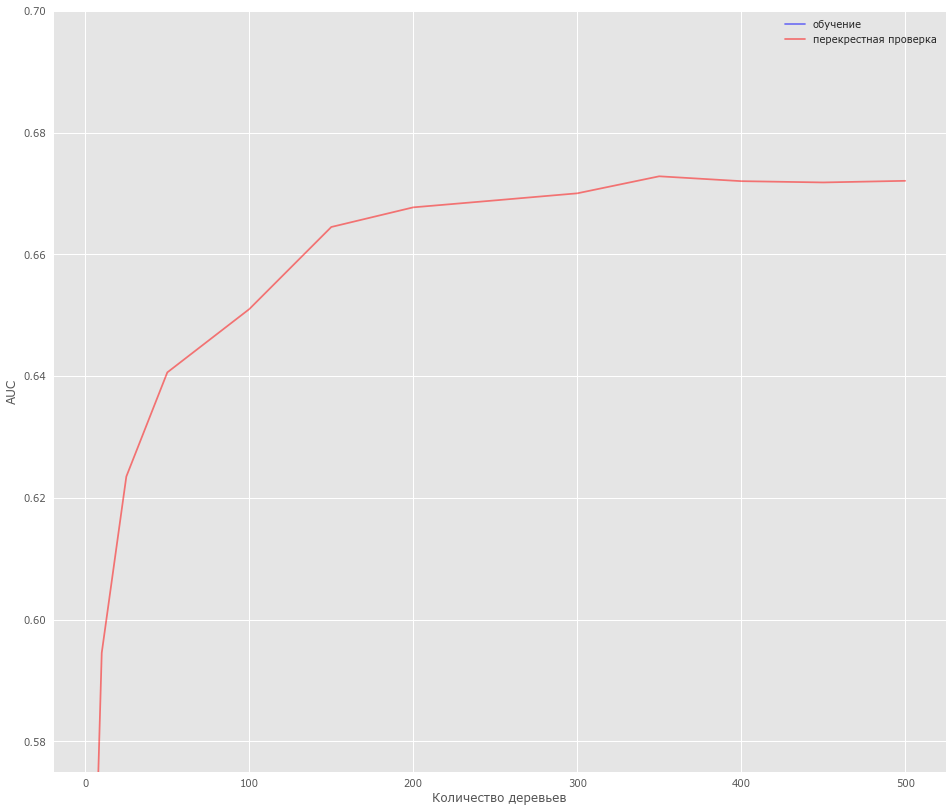

In [234]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(16, 14))
ax.plot(trees_grid, train_auc, alpha=0.5, color='blue', label='обучение')
ax.plot(trees_grid, test_auc, alpha=0.5, color='red', label='перекрестная проверка')
# ax.fill_between(trees_grid, test_auc.mean(axis=1) - test_auc.std(axis=1), test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
# ax.fill_between(trees_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1), test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.575,0.7])
ax.set_ylabel("AUC")
ax.set_xlabel("Количество деревьев")

In [235]:
params = {'max_features': [9, 12, 15, 18, 21, 24, 27, 30, 33], 'max_depth': [3, 4, 5, 7, 9, 12, 15]}

In [236]:
rf = RandomForestClassifier(n_estimators=375, random_state=42)
grid_search = GridSearchCV(rf, params, n_jobs=-1, cv=strat, scoring='roc_auc', verbose=True)

In [237]:
grid_search.fit(Xtrain, ytrain)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 315 out of 315 | elapsed:  3.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=375, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [9, 12, 15, 18, 21, 24, 27, 30, 33], 'max_depth': [3, 4, 5, 7, 9, 12, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=True)

In [238]:
grid_search.best_score_

0.67788663051982867

In [239]:
grid_search.best_params_

{'max_depth': 9, 'max_features': 9}

In [240]:
grid_search.grid_scores_

[mean: 0.67024, std: 0.02241, params: {'max_depth': 3, 'max_features': 9},
 mean: 0.66665, std: 0.02111, params: {'max_depth': 3, 'max_features': 12},
 mean: 0.66634, std: 0.01995, params: {'max_depth': 3, 'max_features': 15},
 mean: 0.66699, std: 0.01932, params: {'max_depth': 3, 'max_features': 18},
 mean: 0.66586, std: 0.01814, params: {'max_depth': 3, 'max_features': 21},
 mean: 0.66489, std: 0.01808, params: {'max_depth': 3, 'max_features': 24},
 mean: 0.66360, std: 0.01983, params: {'max_depth': 3, 'max_features': 27},
 mean: 0.66342, std: 0.01913, params: {'max_depth': 3, 'max_features': 30},
 mean: 0.66184, std: 0.01894, params: {'max_depth': 3, 'max_features': 33},
 mean: 0.67190, std: 0.01953, params: {'max_depth': 4, 'max_features': 9},
 mean: 0.67190, std: 0.01933, params: {'max_depth': 4, 'max_features': 12},
 mean: 0.67167, std: 0.01904, params: {'max_depth': 4, 'max_features': 15},
 mean: 0.66968, std: 0.01952, params: {'max_depth': 4, 'max_features': 18},
 mean: 0.66902

In [241]:
forest = RandomForestClassifier(n_estimators=400, max_depth=9, max_features=9, n_jobs=-1)
forest.fit(Xtrain, ytrain)
roc_auc_score(ytest, forest.predict_proba(Xtest)[:, 1])

0.67985664624398212

In [242]:
roc_auc_score(y, forest.predict_proba(X)[:, 1])

0.68681455610430497

In [243]:
feat_labels = Xtrain.columns
importances =  forest.feature_importances_
indices = np.argsort(importances)[::-1]
display(DataFrame({'feature': feat_labels[indices], 'importance': importances[indices]}))
# for f in range(Xtrain.shape[1]):
#     print("%2d) %-*s %f" % (f + 1, 71,
#                             feat_labels[indices[f]],
#                             importances[indices[f]]))

,feature,importance
0,SOLVENCY,0.0453
1,PERSONAL_INCOME,0.0414
2,AGE,0.0410
3,CREDIT,0.0387
4,WORK_TIME,0.0357
5,FACT_LIVING_TERM,0.0348
6,FST_PAYMENT,0.0316
7,REG_ADDRESS_PROVINCE,0.0303
8,POSTAL_ADDRESS_PROVINCE,0.0299
9,FACT_ADDRESS_PROVINCE,0.0259


## Логистическая регрессия

### Условия

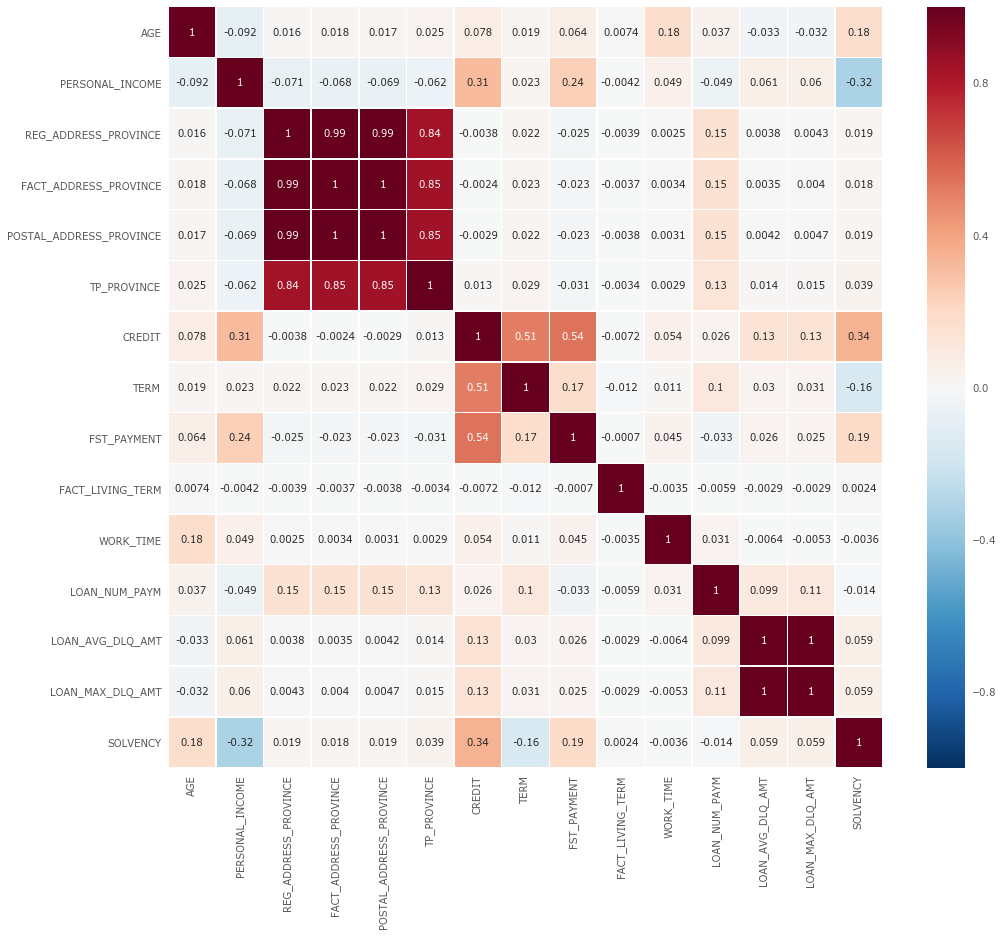

In [244]:
fig, ax = plt.subplots(figsize=(16, 14))

sns.heatmap(train_data.corr(), center=0, annot=True, linewidths=.5)

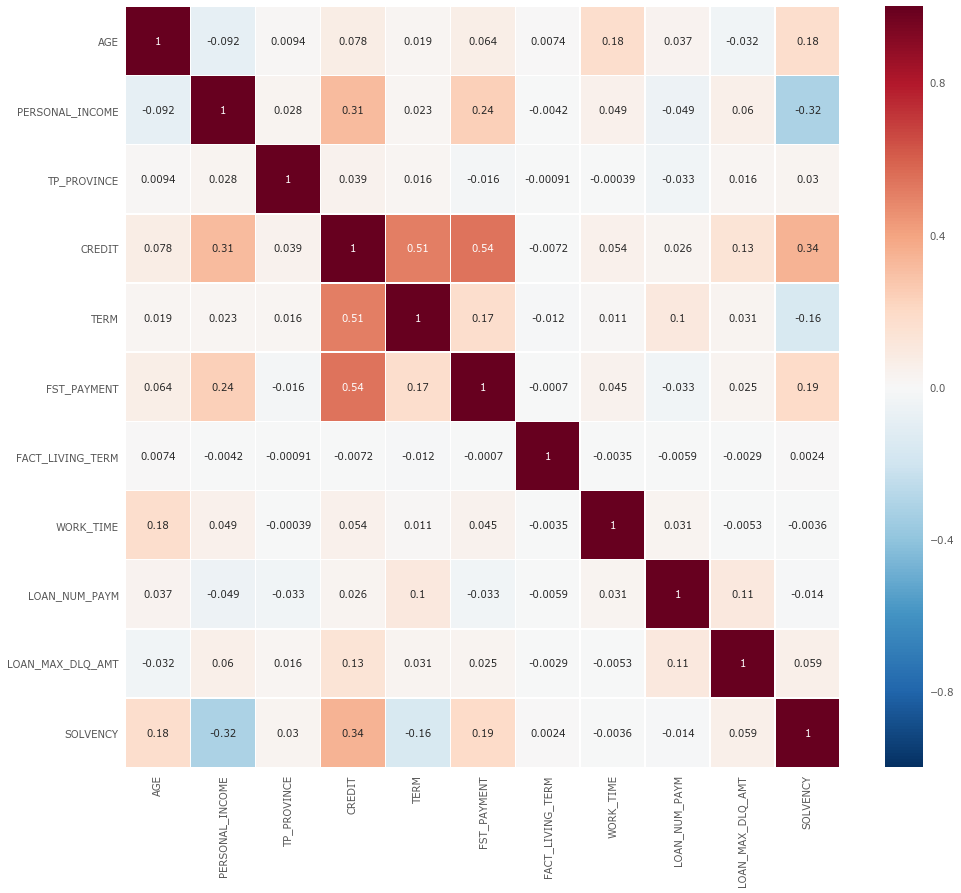

In [245]:
to_drop = ['FACT_ADDRESS_PROVINCE', 'LOAN_AVG_DLQ_AMT', 'REG_ADDRESS_PROVINCE']
tmp_data = train_data.drop(to_drop, axis=1)
tmp_data['TP_PROVINCE'] = tmp_data['TP_PROVINCE']/tmp_data['POSTAL_ADDRESS_PROVINCE']
tmp_data = tmp_data.drop('POSTAL_ADDRESS_PROVINCE', axis=1)
fig, ax = plt.subplots(figsize=(16, 14))

sns.heatmap(tmp_data.corr(), center=0, annot=True, linewidths=.5)

In [246]:
to_drop = ['FACT_ADDRESS_PROVINCE', 'LOAN_AVG_DLQ_AMT', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE']
tmp_data = train_data.drop(to_drop, axis=1)
tmp_data['TP_PROVINCE'] = tmp_data['TP_PROVINCE']/tmp_data['REG_ADDRESS_PROVINCE']

In [247]:
tmp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10656 entries, 2648 to 14963
Data columns (total 48 columns):
TARGET                        10656 non-null object
AGE                           10656 non-null int64
SOCSTATUS_WORK_FL             10656 non-null object
SOCSTATUS_PENS_FL             10656 non-null object
GENDER                        10656 non-null object
CHILD_TOTAL                   10656 non-null object
DEPENDANTS                    10656 non-null object
EDUCATION                     10656 non-null object
MARITAL_STATUS                10656 non-null object
GEN_INDUSTRY                  10656 non-null object
GEN_TITLE                     10656 non-null object
ORG_TP_STATE                  10656 non-null object
ORG_TP_FCAPITAL               10656 non-null object
JOB_DIR                       10656 non-null object
FAMILY_INCOME                 10656 non-null object
PERSONAL_INCOME               10656 non-null float64
REG_ADDRESS_PROVINCE          10656 non-null int64
TP_PR

In [248]:
tmp_cats, tmp_nums = columns(tmp_data)

In [249]:
tmp_nums

['AGE',
 'PERSONAL_INCOME',
 'REG_ADDRESS_PROVINCE',
 'TP_PROVINCE',
 'CREDIT',
 'TERM',
 'FST_PAYMENT',
 'FACT_LIVING_TERM',
 'WORK_TIME',
 'LOAN_NUM_PAYM',
 'LOAN_MAX_DLQ_AMT',
 'SOLVENCY']

AGE


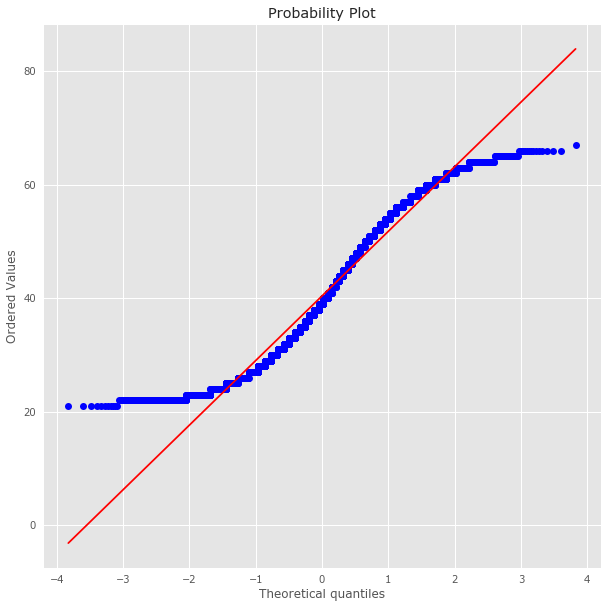

AGE ^1/3


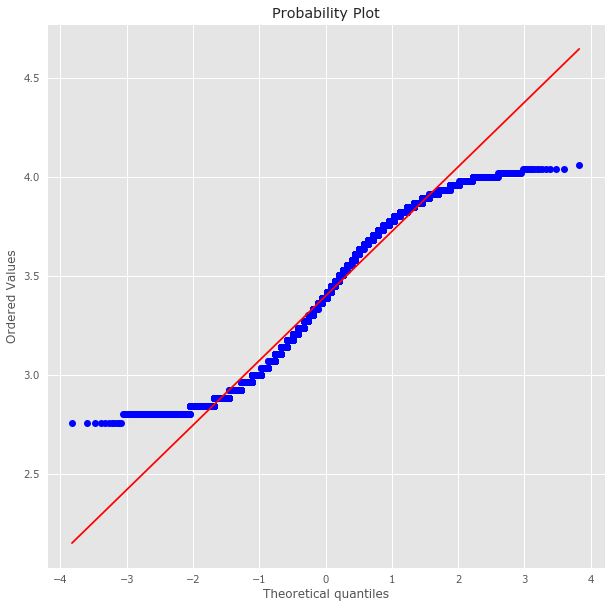


PERSONAL_INCOME


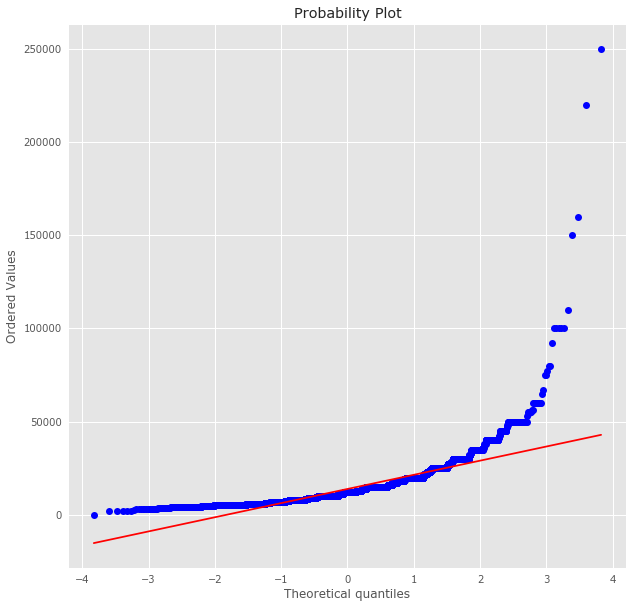

PERSONAL_INCOME ^1/3


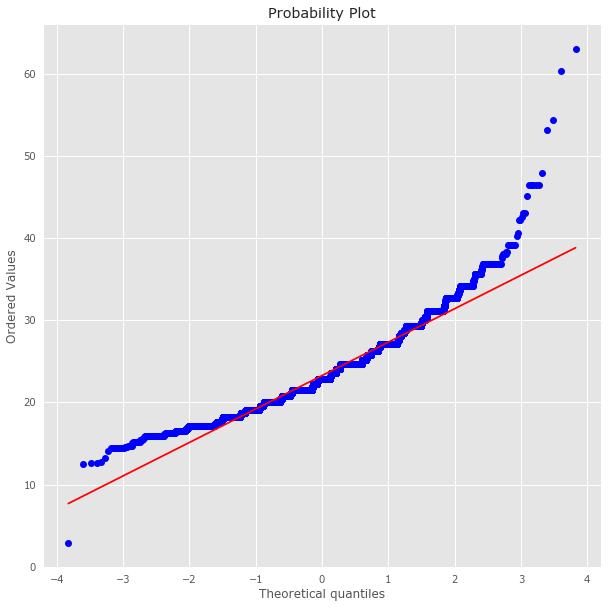


REG_ADDRESS_PROVINCE


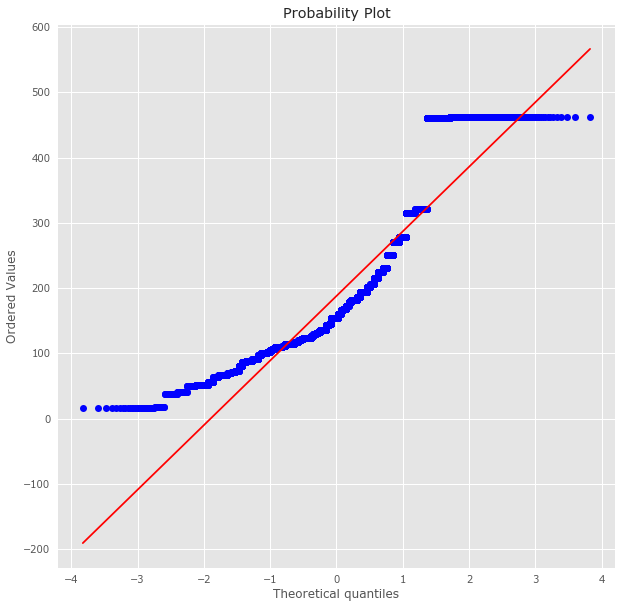

REG_ADDRESS_PROVINCE ^1/3


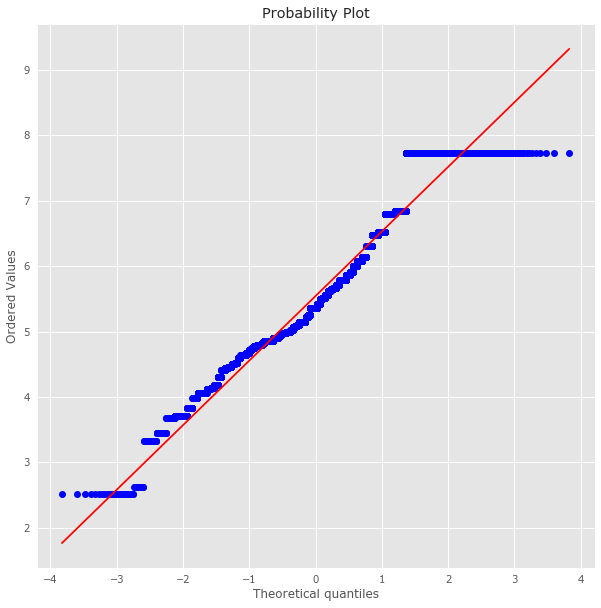


TP_PROVINCE


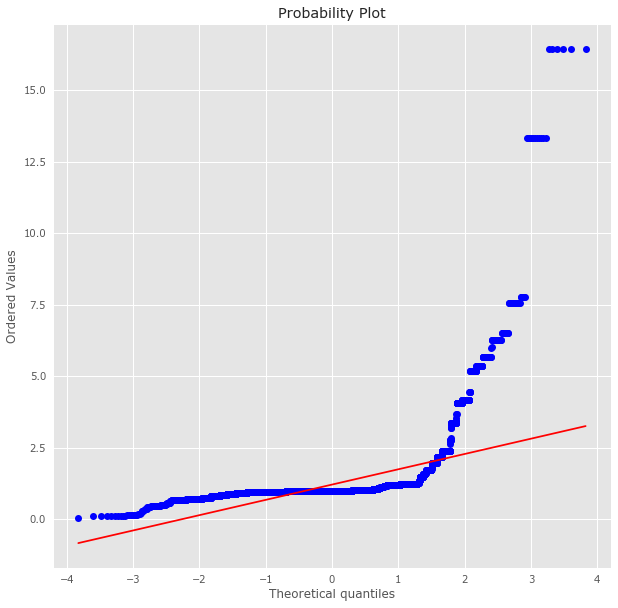

TP_PROVINCE ^1/3


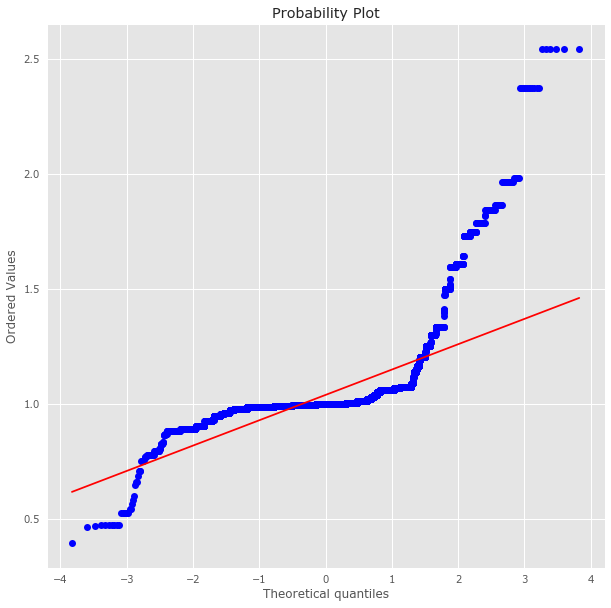


CREDIT


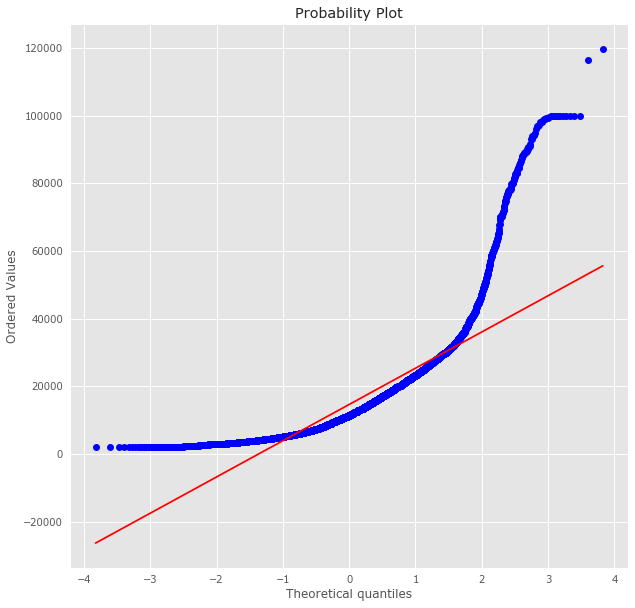

CREDIT ^1/3


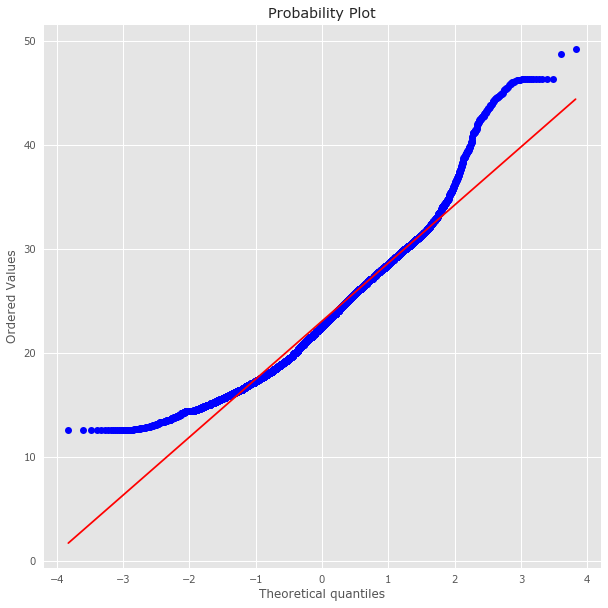


TERM


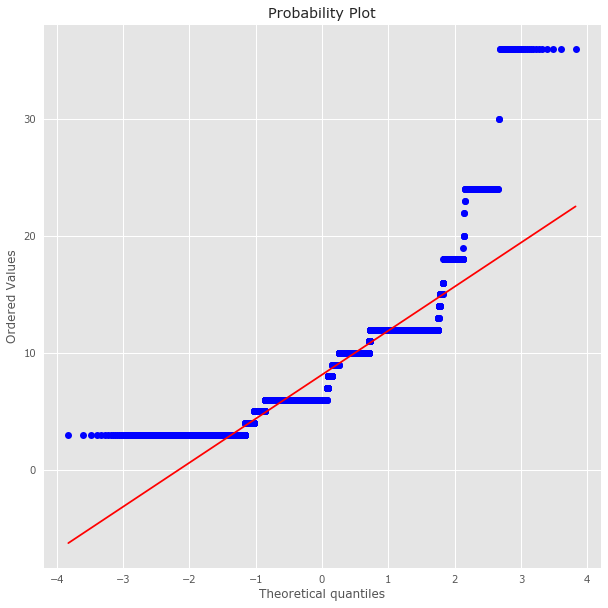

TERM ^1/3


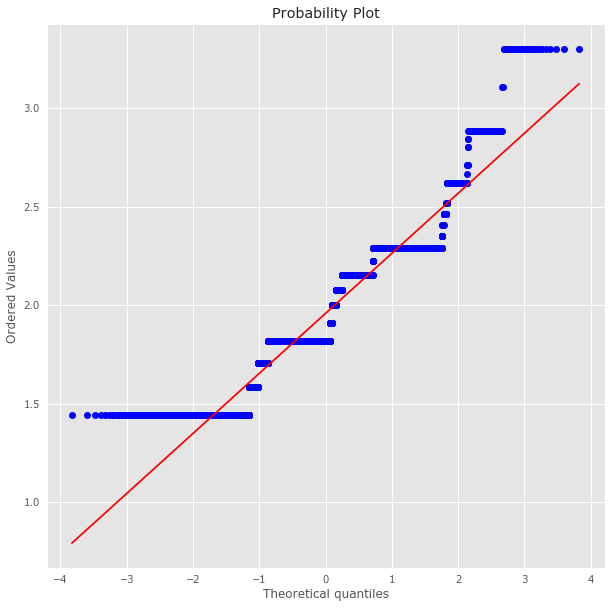


FST_PAYMENT


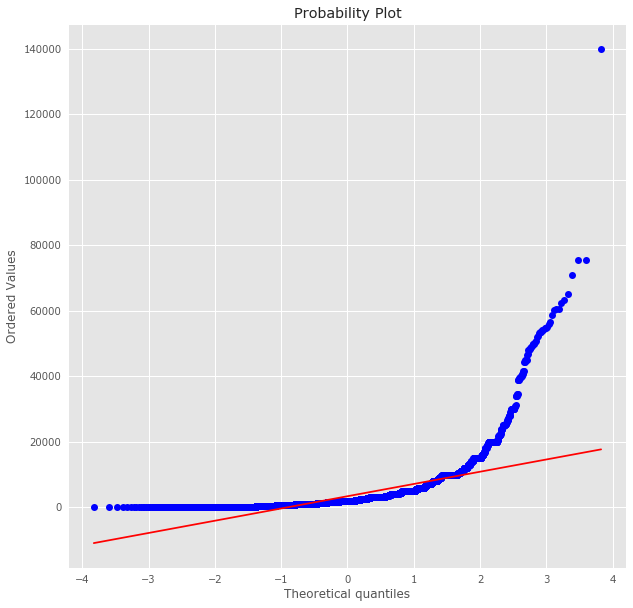

FST_PAYMENT ^1/3


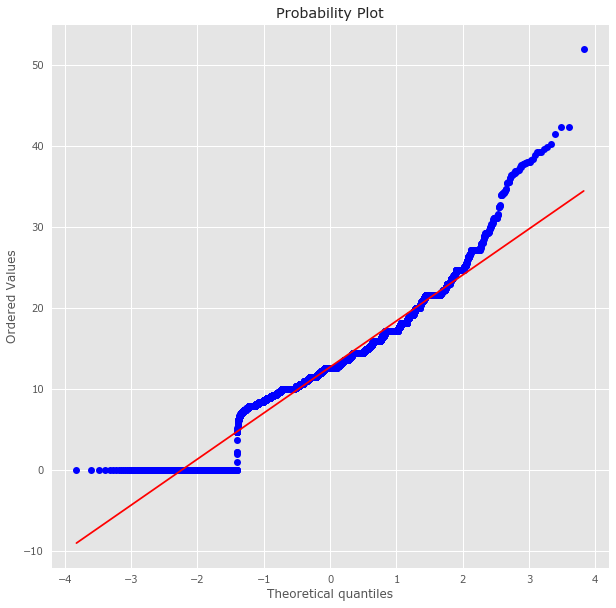


FACT_LIVING_TERM


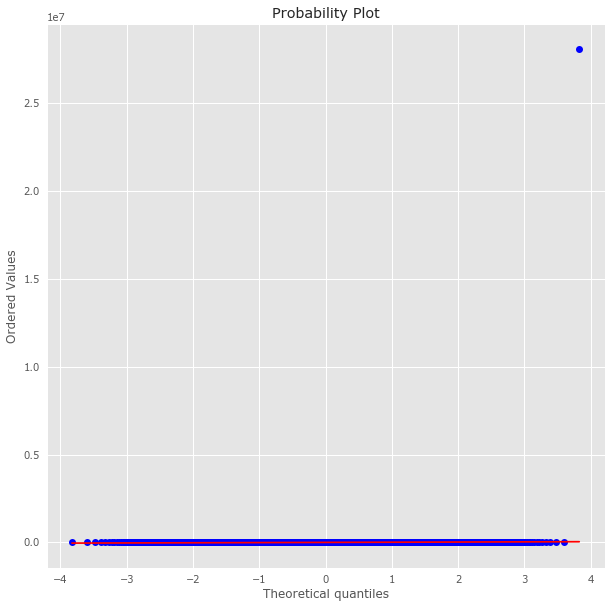

FACT_LIVING_TERM ^1/3


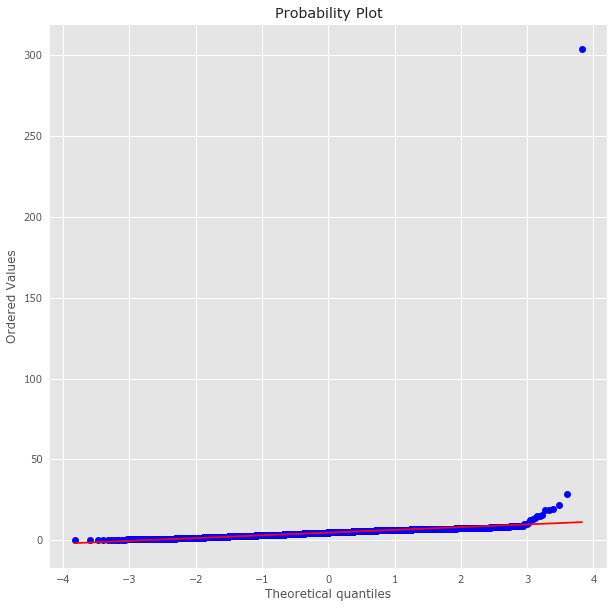


WORK_TIME


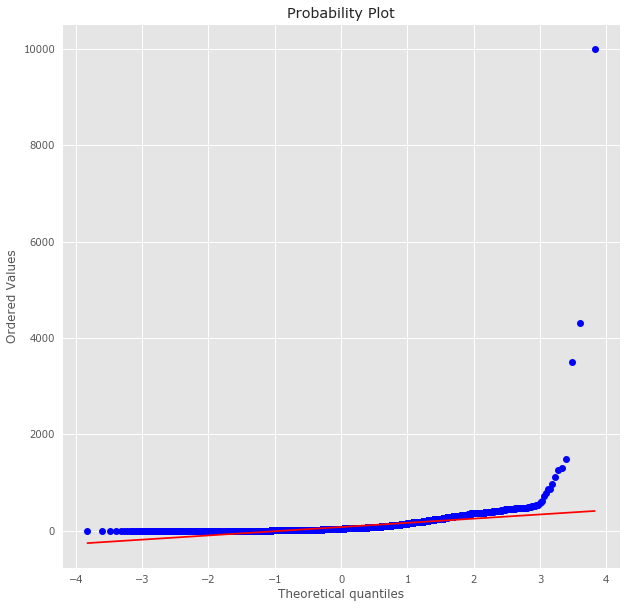

WORK_TIME ^1/3


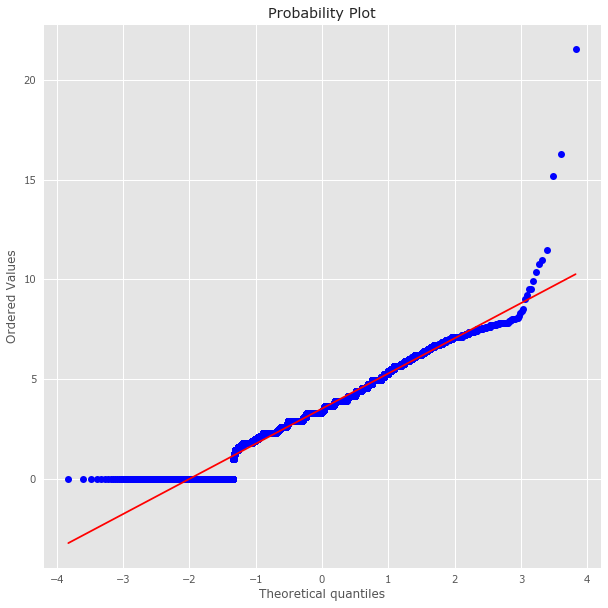


LOAN_NUM_PAYM


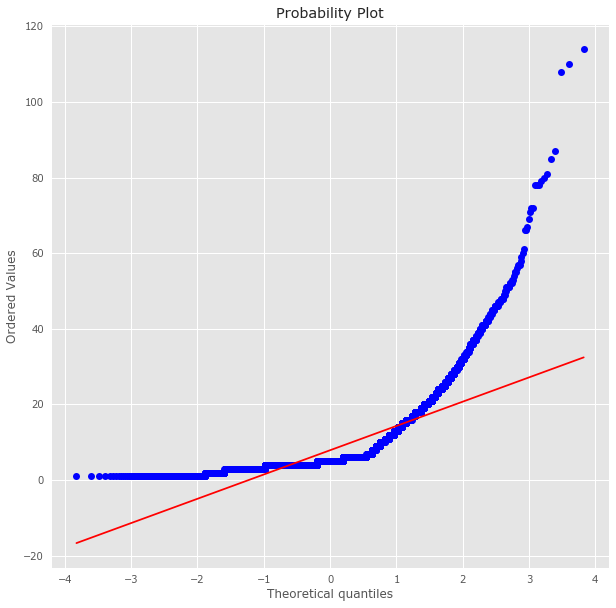

LOAN_NUM_PAYM ^1/3


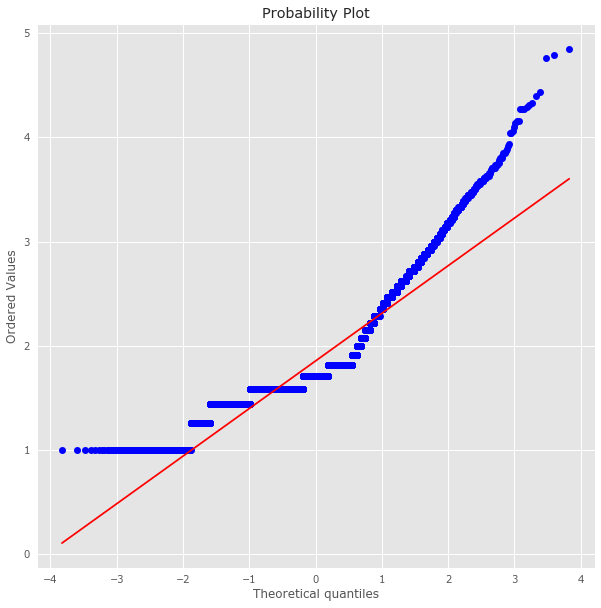


LOAN_MAX_DLQ_AMT


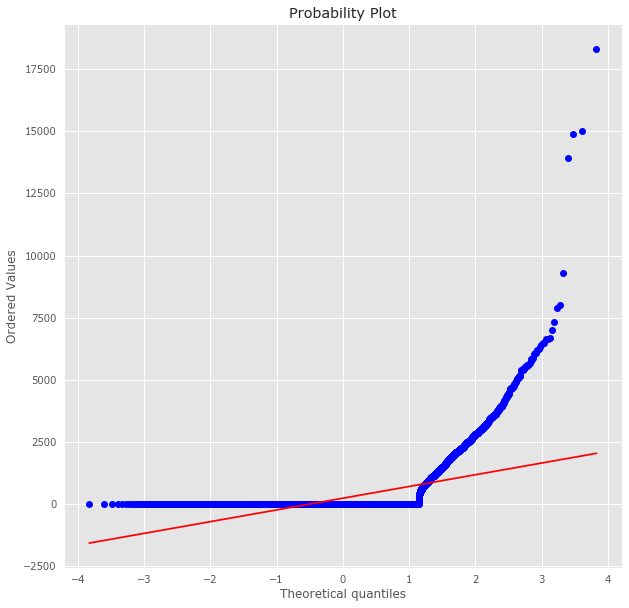

LOAN_MAX_DLQ_AMT ^1/3


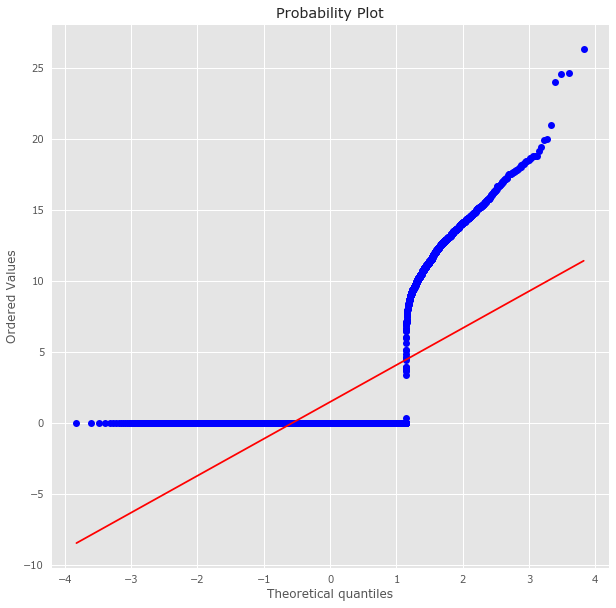


SOLVENCY


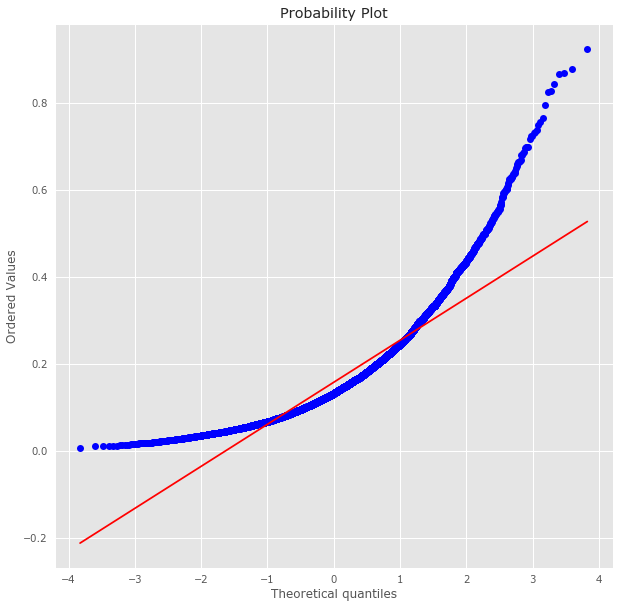

SOLVENCY ^1/3


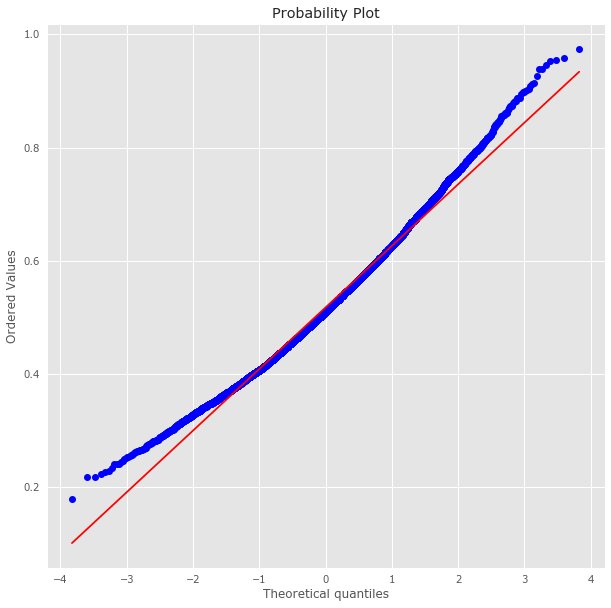

In [250]:
for col in tmp_nums:
    
    plt.subplots(figsize=(10, 10))
    print(col)

    stats.probplot(tmp_data[col], dist="norm", plot=plt)
    plt.show()
    
    plt.subplots(figsize=(10, 10))
    print(col, '^1/3')

    stats.probplot(tmp_data[col]**(1/3), dist="norm", plot=plt)
    plt.show()
    
    print()

In [147]:
def process_for_log_reg(dataset):
    
    to_drop = ['FACT_ADDRESS_PROVINCE', 'LOAN_AVG_DLQ_AMT', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE']
    dataset = dataset.drop(to_drop, axis=1)
    dataset['TP_PROVINCE'] = dataset['TP_PROVINCE']/dataset['REG_ADDRESS_PROVINCE']


    dataset['PERSONAL_INCOME'] = dataset['PERSONAL_INCOME']**(1/3)
    dataset['REG_ADDRESS_PROVINCE'] = dataset['REG_ADDRESS_PROVINCE']**(1/3)
    
    dataset['CREDIT'] = dataset['CREDIT']**(1/3)
    dataset['TERM'] = dataset['TERM']**(1/3)
    
    dataset['FST_PAYMENT'] = dataset['FST_PAYMENT']**(1/3)
    dataset['FACT_LIVING_TERM'] = dataset['FACT_LIVING_TERM']**(1/3)
    
    dataset['WORK_TIME'] = dataset['WORK_TIME']**(1/3)
    dataset['LOAN_NUM_PAYM'] = dataset['LOAN_NUM_PAYM']**(1/3)
    
    dataset['TP_PROVINCE'] = dataset['TP_PROVINCE']**(1/3)

    
    dataset['PERSONAL_INCOME'][dataset['PERSONAL_INCOME'] == np.inf] = 1
    dataset['REG_ADDRESS_PROVINCE'][dataset['REG_ADDRESS_PROVINCE'] == np.inf] = 1
    
    dataset['CREDIT'][dataset['CREDIT'] == np.inf] = 1
    dataset['TERM'][dataset['TERM'] == np.inf] = 1
    
    dataset['FST_PAYMENT'][dataset['FST_PAYMENT'] == np.inf] = 1
    dataset['FACT_LIVING_TERM'][dataset['FACT_LIVING_TERM'] == np.inf] = 1
    
    dataset['WORK_TIME'][dataset['WORK_TIME'] == np.inf] = 1
    dataset['LOAN_NUM_PAYM'][dataset['LOAN_NUM_PAYM'] == np.inf] = 1
    
    dataset['TP_PROVINCE'][dataset['TP_PROVINCE'] == np.inf] = 1
    
    dataset.drop('LOAN_MAX_DLQ_AMT', axis=1, inplace=True)
    
    return dataset

In [148]:
from sklearn.linear_model import LogisticRegression

In [149]:
log_reg = LogisticRegression(n_jobs=-1)

In [150]:
logreg_data = process_for_log_reg(train_data)

In [151]:
logreg_data = pd.get_dummies(logreg_data)

In [152]:
Xtrain_lg, Xtest_lg, ytrain_lg, ytest_lg = train_test_split(logreg_data.drop(['TARGET_0', 'TARGET_1'], axis=1),
                                                            logreg_data.loc[:, 'TARGET_1'], test_size=0.3)

In [153]:
Xtrain_lg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10656 entries, 6011 to 11584
Columns: 171 entries, AGE to DELAY_1
dtypes: float64(9), int64(1), uint8(161)
memory usage: 2.5 MB


In [154]:
Xtest_lg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4567 entries, 2640 to 4332
Columns: 171 entries, AGE to DELAY_1
dtypes: float64(9), int64(1), uint8(161)
memory usage: 1.1 MB


In [155]:
logreg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Columns: 173 entries, AGE to DELAY_1
dtypes: float64(9), int64(1), uint8(163)
memory usage: 3.5 MB


In [156]:
log_reg.fit(Xtrain_lg, ytrain_lg)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [157]:
roc_auc_score(ytest_lg, log_reg.predict_proba(Xtest_lg)[:, 1])

0.703655582095988

In [251]:
import h2o
import os
h2o.init(nthreads = -1, max_mem_size = 12)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,6 hours 56 mins
H2O cluster version:,3.10.4.8
H2O cluster version age:,5 months and 1 day !!!
H2O cluster name:,H2O_from_python_boriszubarev_yt4nc8
H2O cluster total nodes:,1
H2O cluster free memory:,12.03 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [252]:
Xtr, Xts, ytr, yts = train_test_split(train_data.drop('TARGET', axis=1), 
                                      train_data.loc[:, 'TARGET'], test_size=0.3)

In [253]:
training = h2o.H2OFrame(train_data)
validation = h2o.H2OFrame(test_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [254]:
training.describe()

Rows:10656
Cols:51




,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,DELAY,SOLVENCY
type,int,int,int,int,int,int,int,enum,enum,enum,enum,enum,enum,enum,enum,real,int,int,int,int,enum,int,int,int,int,int,int,int,int,int,int,int,int,real,int,real,int,int,int,int,int,int,int,int,int,int,real,real,int,int,real
mins,0.0,21.0,0.0,0.0,0.0,0.0,0.0,,,,,,,,,24.0,16.0,16.0,16.0,12.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0057977777777777776
mean,0.11871246246246246,40.39048423423404,0.909816066066066,0.13541666666666666,0.6589714714714715,1.0976914414414376,0.6518393393393399,,,,,,,,,13857.748795045041,187.89508258258317,187.34084084084066,187.51520270270274,205.57845345345314,,0.8352102102102102,0.950075075075075,0.884009009009009,0.8346471471471472,0.9055930930930931,0.3095908408408408,0.11843093093093093,0.07685810810810811,0.21584084084084085,0.01004129129129129,0.018956456456456456,0.04391891891891892,14699.5335332207,8.135792042042032,3383.503652402409,0.5910285285285285,2775.842811561553,78.0704767267269,0.614771021021021,0.05508633633633633,0.9103791291291291,1.3886073573573592,0.7513138138138156,7.902308558558567,0.19510135135135157,238.87344430567757,242.4836167417416,0.018862612612612614,0.12678303303303304,0.15776753296731091
maxs,1.0,67.0,1.0,1.0,1.0,4.0,4.0,,,,,,,,,250000.0,463.0,465.0,464.0,552.0,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,119700.0,36.0,140000.0,1.0,28101997.0,10000.0,1.0,1.0,1.0,7.0,7.0,114.0,7.0,18307.16,18310.0,1.0,1.0,0.925
sigma,0.32346504071608856,11.609847901127566,0.28645853570544333,0.3421841335150853,0.4740771694392303,0.970194154421922,0.8154033269136831,,,,,,,,,8948.81947595378,107.31718500896059,107.35391504357068,107.25393171944094,119.13559638077783,,0.3710081296918319,0.21780008828092728,0.32022914354697807,0.3715161364348341,0.29240770628788443,0.46234663682399135,0.32313285846552336,0.2663786745592092,0.41142369543144347,0.09970655294098867,0.1363776176763547,0.20492434788769762,12364.383149811449,4.1478823634364455,5240.707425967664,0.49166705449478926,272231.3908746991,145.11537249640486,0.48667220963720265,0.2281594115696431,0.2856512344037868,0.7924903831200092,0.984296293545417,8.077494809872402,0.6618507312663184,808.2994776412752,816.4638736748536,0.13604613692289766,0.3327453769928654,0.10376510684682669
zeros,9391,0,961,9213,3634,3487,5740,,,,,,,,,0,0,0,0,0,,1756,532,1236,1762,1006,7357,9394,9837,8356,10549,10454,10188,0,0,846,4358,12,955,4105,10069,955,0,5452,0,9305,9305,9305,10455,9305,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,41.0,1.0,0.0,0.0,0.0,0.0,Среднее специальное,Не состоял в браке,Коммунальное хоз-во/Дорожные службы,Рабочий,Государственная комп./учреж.,Без участия,Снабжение и сбыт,от 10000 до 20000 руб.,9000.0,91.0,89.0,90.0,89.0,ЮЖНЫЙ,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,11300.0,12.0,1500.0,0.0,195.0,96.0,1.0,0.0,1.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.10462962962962964
1,0.0,56.0,1.0,0.0,1.0,1.0,0.0,Среднее,Не состоял в браке,Металлургия/Промышленность/Машиностроение,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,17000.0,131.0,134.0,133.0,140.0,ЦЕНТРАЛЬНЫЙ 2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,18000.0,4.0,5000.0,1.0,60.0,108.0,1.0,0.0,1.0,

In [264]:
validation.describe()

Rows:4567
Cols:51




,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,DELAY,SOLVENCY
type,int,int,int,int,int,int,int,enum,enum,enum,enum,enum,enum,enum,enum,real,int,int,int,int,enum,int,int,int,int,int,int,int,int,int,int,int,int,real,int,real,int,int,int,int,int,int,int,int,int,int,real,real,int,int,real
mins,0.0,21.0,0.0,0.0,0.0,0.0,0.0,,,,,,,,,3000.0,16.0,16.0,16.0,12.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.008976190476190476
mean,0.11977227939566455,40.44252244361713,0.9091307203853733,0.13225312021020363,0.6441865557258595,1.0770746660827666,0.6262316619224872,,,,,,,,,13844.707508211095,190.05693015108386,189.521348806656,189.69038756295132,206.79789796365262,,0.8462885920735713,0.9537989927742501,0.8918327129406612,0.8460696299540179,0.904751477994307,0.3102693234070506,0.11123275673308518,0.0672213707028684,0.21523976352091087,0.009196409021239325,0.01992555287935187,0.0431355375520035,14594.288543901886,8.019925552879341,3433.6992292533473,0.5830961243704839,3654.151740748871,708.6713378585499,0.6043354499671557,0.054083643529669365,0.90956864462448,1.3842785198160723,0.7519159185460909,7.814539084738351,0.18765053645719257,240.81906678467234,244.27694328881114,0.019049704401138602,0.12502737026494418,0.16093600042289463
maxs,1.0,66.0,1.0,1.0,1.0,4.0,4.0,,,,,,,,,250000.0,463.0,465.0,464.0,552.0,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100000.0,36.0,75500.0,1.0,16091983.0,2867959.0,1.0,1.0,1.0,7.0,7.0,87.0,7.0,28012.2,28012.2,1.0,1.0,1.1904761904761905
sigma,0.32473061148123483,11.581744570750688,0.2874545990395076,0.3388028430960012,0.47881148325726186,0.9451526652159421,0.7857381628485758,,,,,,,,,9170.07461454015,109.0235010632628,108.79410451228385,108.85703955595994,119.94518975654583,,0.36071138151220195,0.20994314744440368,0.31062558223978604,0.36092150694881425,0.2935900450056096,0.4626544488197951,0.3144545784454385,0.25043240712315723,0.4110335765654161,0.09546638500557816,0.13975980167976418,0.2031844053142657,11628.022416657726,3.965002027836354,4960.423433027946,0.4931006736723529,238117.09572638286,42437.141958874774,0.48904650318761844,0.22620744302892545,0.2868301582664838,0.7826120663885964,0.9880938985139475,7.664675053233116,0.6292935728613026,871.3795129349568,880.3058387733397,0.13671468744692444,0.33078616306018593,0.10969834113369516
zeros,4020,0,415,3963,1625,1497,2486,,,,,,,,,0,0,0,0,0,,702,211,494,703,435,3150,4059,4260,3584,4525,4476,4370,0,0,362,1904,9,0,1807,4320,413,0,2339,0,3996,3996,3996,4480,3996,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.0,43.0,1.0,0.0,0.0,3.0,3.0,Среднее,Состою в браке,Строительство,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,20000.0,71.0,68.0,68.0,296.0,ЮЖНЫЙ,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8970.0,6.0,0.0,1.0,48.0,120.0,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.07475000000000001
1,0.0,39.0,1.0,0.0,1.0,0.0,0.0,Высшее,Разведен(а),Здравоохранение,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,10000.0,172.0,170.0,172.0,212.0,ВОСТОЧНО-СИБИРСКИЙ,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5590.0,12.0,0.0,1.0,31.0,9.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0,630.0,630.0,0.0,1.0,0.04658333333333333

In [269]:
cats, nums = columns(train_data)

In [270]:
for i in cats:
    
    training[i] = training[i].asfactor()
    validation[i] = validation[i].asfactor()

In [271]:
'TARGET' in list(Xtrain.columns)

False

In [272]:
X_col = list(Xtr.columns)
y_col = 'TARGET'

In [273]:
from h2o.estimators import H2ORandomForestEstimator

In [274]:
rf1 = H2ORandomForestEstimator(model_id='RF_OTP', ntrees=800, max_depth=14, score_tree_interval=100, seed=42)

In [275]:
rf1.train(X_col, y_col, training_frame=training, validation_frame=validation)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [276]:
rf1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  RF_OTP


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.1003842817438297
RMSE: 0.31683478619594424
LogLoss: 0.3447445546893976
Mean Per-Class Error: 0.3697893829050858
AUC: 0.6754282020082301
Gini: 0.3508564040164601
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1628611188915468: 


,0,1,Error,Rate
0,7428.0,1963.0,0.209,(1963.0/9391.0)
1,710.0,555.0,0.5613,(710.0/1265.0)
Total,8138.0,2518.0,0.2508,(2673.0/10656.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1628611,0.2934179,180.0
max f2,0.0860620,0.4474391,295.0
max f0point5,0.1821739,0.2550725,158.0
max accuracy,0.4914228,0.8814752,3.0
max precision,0.5803791,1.0,0.0
max recall,0.0025521,1.0,398.0
max specificity,0.5803791,1.0,0.0
max absolute_mcc,0.1628611,0.1748982,180.0
max min_per_class_accuracy,0.1268076,0.6207007,231.0
max mean_per_class_accuracy,0.1220122,0.6302106,239.0


Gains/Lift Table: Avg response rate: 11,87 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100413,0.6549147,8.4237154,8.4237154,1.0,1.0,0.0845850,0.0845850,742.3715415,742.3715415
,2,0.0200826,0.5980586,8.4237154,8.4237154,1.0,1.0,0.0845850,0.1691700,742.3715415,742.3715415
,3,0.0300300,0.5570243,8.4237154,8.4237154,1.0,1.0,0.0837945,0.2529644,742.3715415,742.3715415
,4,0.0400713,0.5153439,8.4237154,8.4237154,1.0,1.0,0.0845850,0.3375494,742.3715415,742.3715415
,5,0.0500188,0.4735631,8.4237154,8.4237154,1.0,1.0,0.0837945,0.4213439,742.3715415,742.3715415
,6,0.1000375,0.2868820,8.4237154,8.4237154,1.0,1.0,0.4213439,0.8426877,742.3715415,742.3715415
,7,0.1500563,0.1497075,3.0502384,6.6325564,0.3621013,0.7873671,0.1525692,0.9952569,205.0238415,563.2556415
,8,0.2000751,0.1286818,0.0632174,4.9902217,0.0075047,0.5924015,0.0031621,0.9984190,-93.6782624,399.0221655
,9,0.3000188,0.1070637,0.0158192,3.3331248,0.0018779,0.3956835,0.0015810,1.0,-98.4180816,233.3124805
,10,0.4000563,0.0930164,0.0,2.4996481,0.0,0.2967394,0.0,1.0,-100.0,149.9648135




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.10063554167584064
RMSE: 0.3172310540849377
LogLoss: 0.3446656670357528
Mean Per-Class Error: 0.3589802359318581
AUC: 0.6847374189382157
Gini: 0.36947483787643143
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15777183980598825: 


,0,1,Error,Rate
0,3104.0,916.0,0.2279,(916.0/4020.0)
1,288.0,259.0,0.5265,(288.0/547.0)
Total,3392.0,1175.0,0.2636,(1204.0/4567.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1577718,0.3008130,178.0
max f2,0.1008516,0.4540742,265.0
max f0point5,0.2256544,0.2652068,105.0
max accuracy,0.5470840,0.8802277,1.0
max precision,0.5470840,0.5,1.0
max recall,0.0077981,1.0,394.0
max specificity,0.5693694,0.9997512,0.0
max absolute_mcc,0.1245678,0.1854928,227.0
max min_per_class_accuracy,0.1290773,0.6325411,221.0
max mean_per_class_accuracy,0.1245678,0.6410198,227.0


Gains/Lift Table: Avg response rate: 11,98 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100723,0.3474096,2.1780463,2.1780463,0.2608696,0.2608696,0.0219378,0.0219378,117.8046260,117.8046260
,2,0.0201445,0.3090003,3.0855655,2.6318059,0.3695652,0.3152174,0.0310786,0.0530165,208.5565535,163.1805898
,3,0.0299978,0.2848818,2.7830591,2.6814876,0.3333333,0.3211679,0.0274223,0.0804388,178.3059110,168.1487610
,4,0.0400701,0.2697405,2.7225578,2.6918113,0.3260870,0.3224044,0.0274223,0.1078611,172.2557825,169.1811271
,5,0.0501423,0.2553669,2.3595501,2.6250689,0.2826087,0.3144105,0.0237660,0.1316271,135.9550115,162.5068855
,6,0.1000657,0.2137504,1.7211023,2.1740746,0.2061404,0.2603939,0.0859232,0.2175503,72.1102345,117.4074622
,7,0.1499891,0.1893071,1.5746255,1.9745500,0.1885965,0.2364964,0.0786106,0.2961609,57.4625549,97.4549967
,8,0.2001314,0.1709264,1.8594238,1.9457054,0.2227074,0.2330416,0.0932358,0.3893967,85.9423772,94.5705439
,9,0.2999781,0.1465971,1.2816720,1.7246841,0.1535088,0.2065693,0.1279707,0.5173675,28.1671959,72.4684076
,10,0.4000438,0.1283197,1.2057893,1.5948894,0.1444201,0.1910235,0.1206581,0.6380256,20.5789286,59.4889375



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-10-23 00:54:14,0.035 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2017-10-23 00:54:16,1.959 sec,100.0,0.3199006,0.3537952,0.6489881,8.4237154,0.3629880,0.3179883,0.3477585,0.6731136,2.3595501,0.3056711
,2017-10-23 00:54:19,4.554 sec,200.0,0.3180011,0.3472885,0.6653198,8.4237154,0.2962650,0.3175555,0.3461390,0.6770519,2.9040617,0.2432669
,2017-10-23 00:54:22,7.850 sec,300.0,0.3177341,0.3471085,0.6660234,8.4237154,0.28125,0.3175816,0.3458305,0.6794139,2.7225578,0.2426100
,2017-10-23 00:54:26,11.991 sec,400.0,0.3172482,0.3458346,0.6703455,8.4237154,0.2948574,0.3174329,0.3453314,0.6816118,2.1780463,0.3372017
,2017-10-23 00:54:31,16.961 sec,500.0,0.3171774,0.3456152,0.6713614,8.4237154,0.3186937,0.3173882,0.3451347,0.6823576,2.1780463,0.2614408
,2017-10-23 00:54:37,22.861 sec,600.0,0.3170478,0.3453328,0.6726378,8.4237154,0.2955143,0.3172620,0.3449031,0.6839516,1.9965424,0.2785198
,2017-10-23 00:54:44,29.639 sec,700.0,0.3169902,0.3451519,0.6734102,8.4237154,0.2749625,0.3172257,0.3447338,0.6849066,2.1780463,0.2651631
,2017-10-23 00:54:51,37.336 sec,800.0,0.3168348,0.3447446,0.6754282,8.4237154,0.2508446,0.3172311,0.3446657,0.6847374,2.1780463,0.2636304


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
GEN_INDUSTRY,34213.1445312,1.0,0.1090730
REGION_NM,23298.2539062,0.6809738,0.0742758
GEN_TITLE,16519.1757812,0.4828313,0.0526638
AGE,16250.5634766,0.4749801,0.0518075
SOLVENCY,13600.7216797,0.3975291,0.0433597
---,---,---,---
FACT_POST_FL,1125.7874756,0.0329051,0.0035891
COT_PRESENCE_FL,536.7827148,0.0156894,0.0017113
GEN_PHONE_FL,516.8374023,0.0151064,0.0016477
SOCSTATUS_WORK_FL,489.2012329,0.0142986,0.0015596



See the whole table with table.as_data_frame()


In [277]:
predictions = rf1.predict(validation)
predictions

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
1,0.766968,0.233032
1,0.746201,0.253799
0,0.923811,0.0761888
0,0.9832,0.0167996
0,0.888398,0.111602
0,0.865178,0.134822
0,0.851778,0.148222
0,0.920579,0.0794206
0,0.868928,0.131072
0,0.862965,0.137035


In [279]:
import lightgbm

ModuleNotFoundError: No module named 'lightgbm'